# Crosscheck the BDT training and calibration on Run 2 data
- Author: Vincenzo Battista (vibattis)
- Start Date: 2017-10-24
- End Date: 2017-11-30
    
# Goals
- reproduce the Run 2 OSElectron tagger (with newly optimized cuts) on Run 2 data
- produce a tuple for external EPM-calibration
- cross-check EPM calibration with minimal python-based calibration of the raw BDT output

# Conclusion
- the calibrated, per-event mistag with cuts optimised on Run 2 is ~0.34%, a bit lower than the Run 1 result of 0.37%
- results from calibration with logistic regression "by hand" and by EPM are compatible.

In [1]:
# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 1

# https://github.com/jrjohansson/version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas, root_pandas, root_numpy

import matplotlib
matplotlib.rc_file('../../lhcb-matplotlibrc/matplotlibrc')
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
%config InlineBackend.figure_format = 'retina'

In [2]:
#"Standard" libraries import
import pandas as pd
import math
from root_pandas import read_root
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xgboost
from xgboost import XGBClassifier
from xgboost.core import Booster
from xgboost.sklearn import XGBModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import column_or_1d
from sklearn.metrics import roc_curve
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from uncertainties import ufloat
from scipy.stats import ks_2samp
from IPython.display import Image, display
import json
import os, sys

#"Local" library import
sys.path.append("../../python/")
import calib_models, calib_utils, data_utils, plot_utils, tagging_utils, mva_utils, stat_utils

#Set up logging
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Set LHCb style for plots
#import matplotlib
#matplotlib.rc_file('../../lhcb-matplotlibrc/matplotlibrc')

In [4]:
# Customizations
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (12, 12)
#%config InlineBackend.figure_format = 'retina'

In [5]:
# notebook name
notebook_name = '2017-12-12-vibattis-OSElectron-bdt-calibration-sWeights_Run2'
# Find the notebook the saved figures came from
fig_prefix = '../figures/'+notebook_name+'/'
# Directory to store weights
weights_prefix = '../weights/'+notebook_name+'/'

In [6]:
# input file and tree names
file_in_run2_train = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_bdt.root'
file_in_run2_eval1 = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_eval1.root'
file_in_run2_eval2 = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_eval2.root'
base_file = '/eos/lhcb/wg/FlavourTagging/tuples/development/data/B2CC/20170628_kheinick/DTT_2016_Reco16Strip28_20170628_kheinicke_sweights.root'
base_tree = 'Bu2JpsiKDetached'

In [7]:
pfx="B_OSMuonDev_TagPartsFeature_"
mva_dictionary = {
    "Features": {
       #pfx+"P"                     : {"bins": 80, "log": True, "label": "$P$ [MeV/c]"},# "max":50000},
       pfx+"PT"                    : {"bins": 80, "log": True, "label": "$P_T$ [MeV/c]"},# "max":4000},
       pfx+"IPPUSig"               : {"bins": 80, "log": True, "label": "$\sigma_{IPPU}/IPPU$"},
       #pfx+"TRGHP"                 : {"bins": 80, "log": True, "label": "Ghost probability"},
       #pfx+"TRCHI2DOF"             : {"bins": 80, "log": True, "label": "Track $\chi^2/ndof$"},
       pfx+"countTracks"           : {"bins": 60, "log": True, "label": "Number of tracks"},
       pfx+"Signal_PT"             : {"bins": 80, "log": True, "label": "Signal $P_{T}$ [Mev/c]"},# "max":40000},
       pfx+"eOverP"                : {"bins": 80, "log": True, "label": "e/P"},
       pfx+"AbsIP"                 : {"bins": 80, "log": True, "label": "|IP| [mm]"},# "max":40},
       pfx+"IPErr"                 : {"bins": 80, "log": True, "label": "$\sigma_{IP}$ [mm]"},# "max":0.4},
       pfx+"BPVIPCHI2"             : {"bins": 80, "log": True, "label": "BPV IP $\chi^2$"},# "max":50000},
       pfx+"PROBNNghost_MC15TuneV1": {"bins": 80, "log": True, "label": "PROBNN ghost"},
       pfx+"DeltaQ"                : {"bins": 80, "log": True, "label": "$\Delta Q$ [MeV/c]"},# "max":5000},
       pfx+"etaDistance"           : {"bins": 80, "log": True, "label": "$\Delta\eta$"},# "max":5}
       pfx+"DeltaR"                : {"bins": 80, "log": True, "label": "$\Delta R$ [mm]"},
        },
    "Target": {
        'target==0' : 'Wrong Tag',                                                                                                                                                                          
        'target==1' : 'Right Tag' } 
    }

In [8]:
# create train and evaluation sample
from data_utils import load_data_fast, sel_efficiency, tot_event_number

train_query = 'eventNumber % 8 >= 2 & eventNumber % 8 <= 5'
eval1_query = 'eventNumber % 8 == 6'
eval2_query = 'eventNumber % 8 == 7'

df_train_run2 = load_data_fast(file_in_run2_train)
df_eval1_run2 = load_data_fast(file_in_run2_eval1)
df_eval2_run2 = load_data_fast(file_in_run2_eval2)

target = '(abs(B_ID) / B_ID) == -B_OSMuonDev_TagPartsFeature_Q'
df_train_run2['target'] = df_train_run2.eval(target)
df_eval1_run2['target'] = df_eval1_run2.eval(target)
df_eval2_run2['target'] = df_eval2_run2.eval(target)

train_event_number_run2 = tot_event_number(base_file, 
                                base_tree,
                                preselection = 'B_LOKI_MASS_JpsiConstr_NoPVConstr>0 & '+train_query,
                                presel_column = ['B_LOKI_MASS_JpsiConstr_NoPVConstr', 'eventNumber'])

eval1_event_number_run2 = tot_event_number(base_file, 
                                base_tree,
                                preselection = 'B_LOKI_MASS_JpsiConstr_NoPVConstr>0 & '+eval1_query,
                                presel_column = ['B_LOKI_MASS_JpsiConstr_NoPVConstr', 'eventNumber'])

eval2_event_number_run2 = tot_event_number(base_file, 
                                base_tree,
                                preselection = 'B_LOKI_MASS_JpsiConstr_NoPVConstr>0 & '+eval2_query,
                                presel_column = ['B_LOKI_MASS_JpsiConstr_NoPVConstr', 'eventNumber'])

print(f'Total number of event before selection in the train sample: {train_event_number_run2}')
print(f'Total number of event before selection in the eval1 sample: {eval1_event_number_run2}')
print(f'Total number of event before selection in the eval2 sample: {eval2_event_number_run2}')
print(f'...sum = {train_event_number_run2+eval1_event_number_run2+eval2_event_number_run2}')

print('Selection efficiency on train sample:')
train_selection_efficiency_run2 = sel_efficiency(df_train_run2, 
                                                 train_event_number_run2)
print('Selection efficiency on eval1 sample:')
eval1_selection_efficiency_run2 = sel_efficiency(df_eval1_run2, 
                                                eval1_event_number_run2)
print('Selection efficiency on calib sample:')
eval2_selection_efficiency_run2 = sel_efficiency(df_eval2_run2, 
                                                 eval2_event_number_run2)

merged_event_number_run2 = eval1_event_number_run2+eval2_event_number_run2
df_merged_run2 = pd.concat([df_eval1_run2,df_eval2_run2])
print('Selection efficiency on the "non-training" sample:')
merged_selection_efficiency_run2 = sel_efficiency(df_merged_run2, 
                                                merged_event_number_run2)

Total number of event before selection in the train sample: 566944.6729904242
Total number of event before selection in the eval1 sample: 141892.29983671446
Total number of event before selection in the eval2 sample: 141652.78557756369
...sum = 850489.7584047023
Selection efficiency on train sample:
INFO:data_utils:ε = 2.5124+/-0.0208%
Selection efficiency on eval1 sample:
INFO:data_utils:ε = 2.5103+/-0.0415%
Selection efficiency on calib sample:
INFO:data_utils:ε = 2.5233+/-0.0417%
Selection efficiency on the "non-training" sample:
INFO:data_utils:ε = 2.5168+/-0.0294%


/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


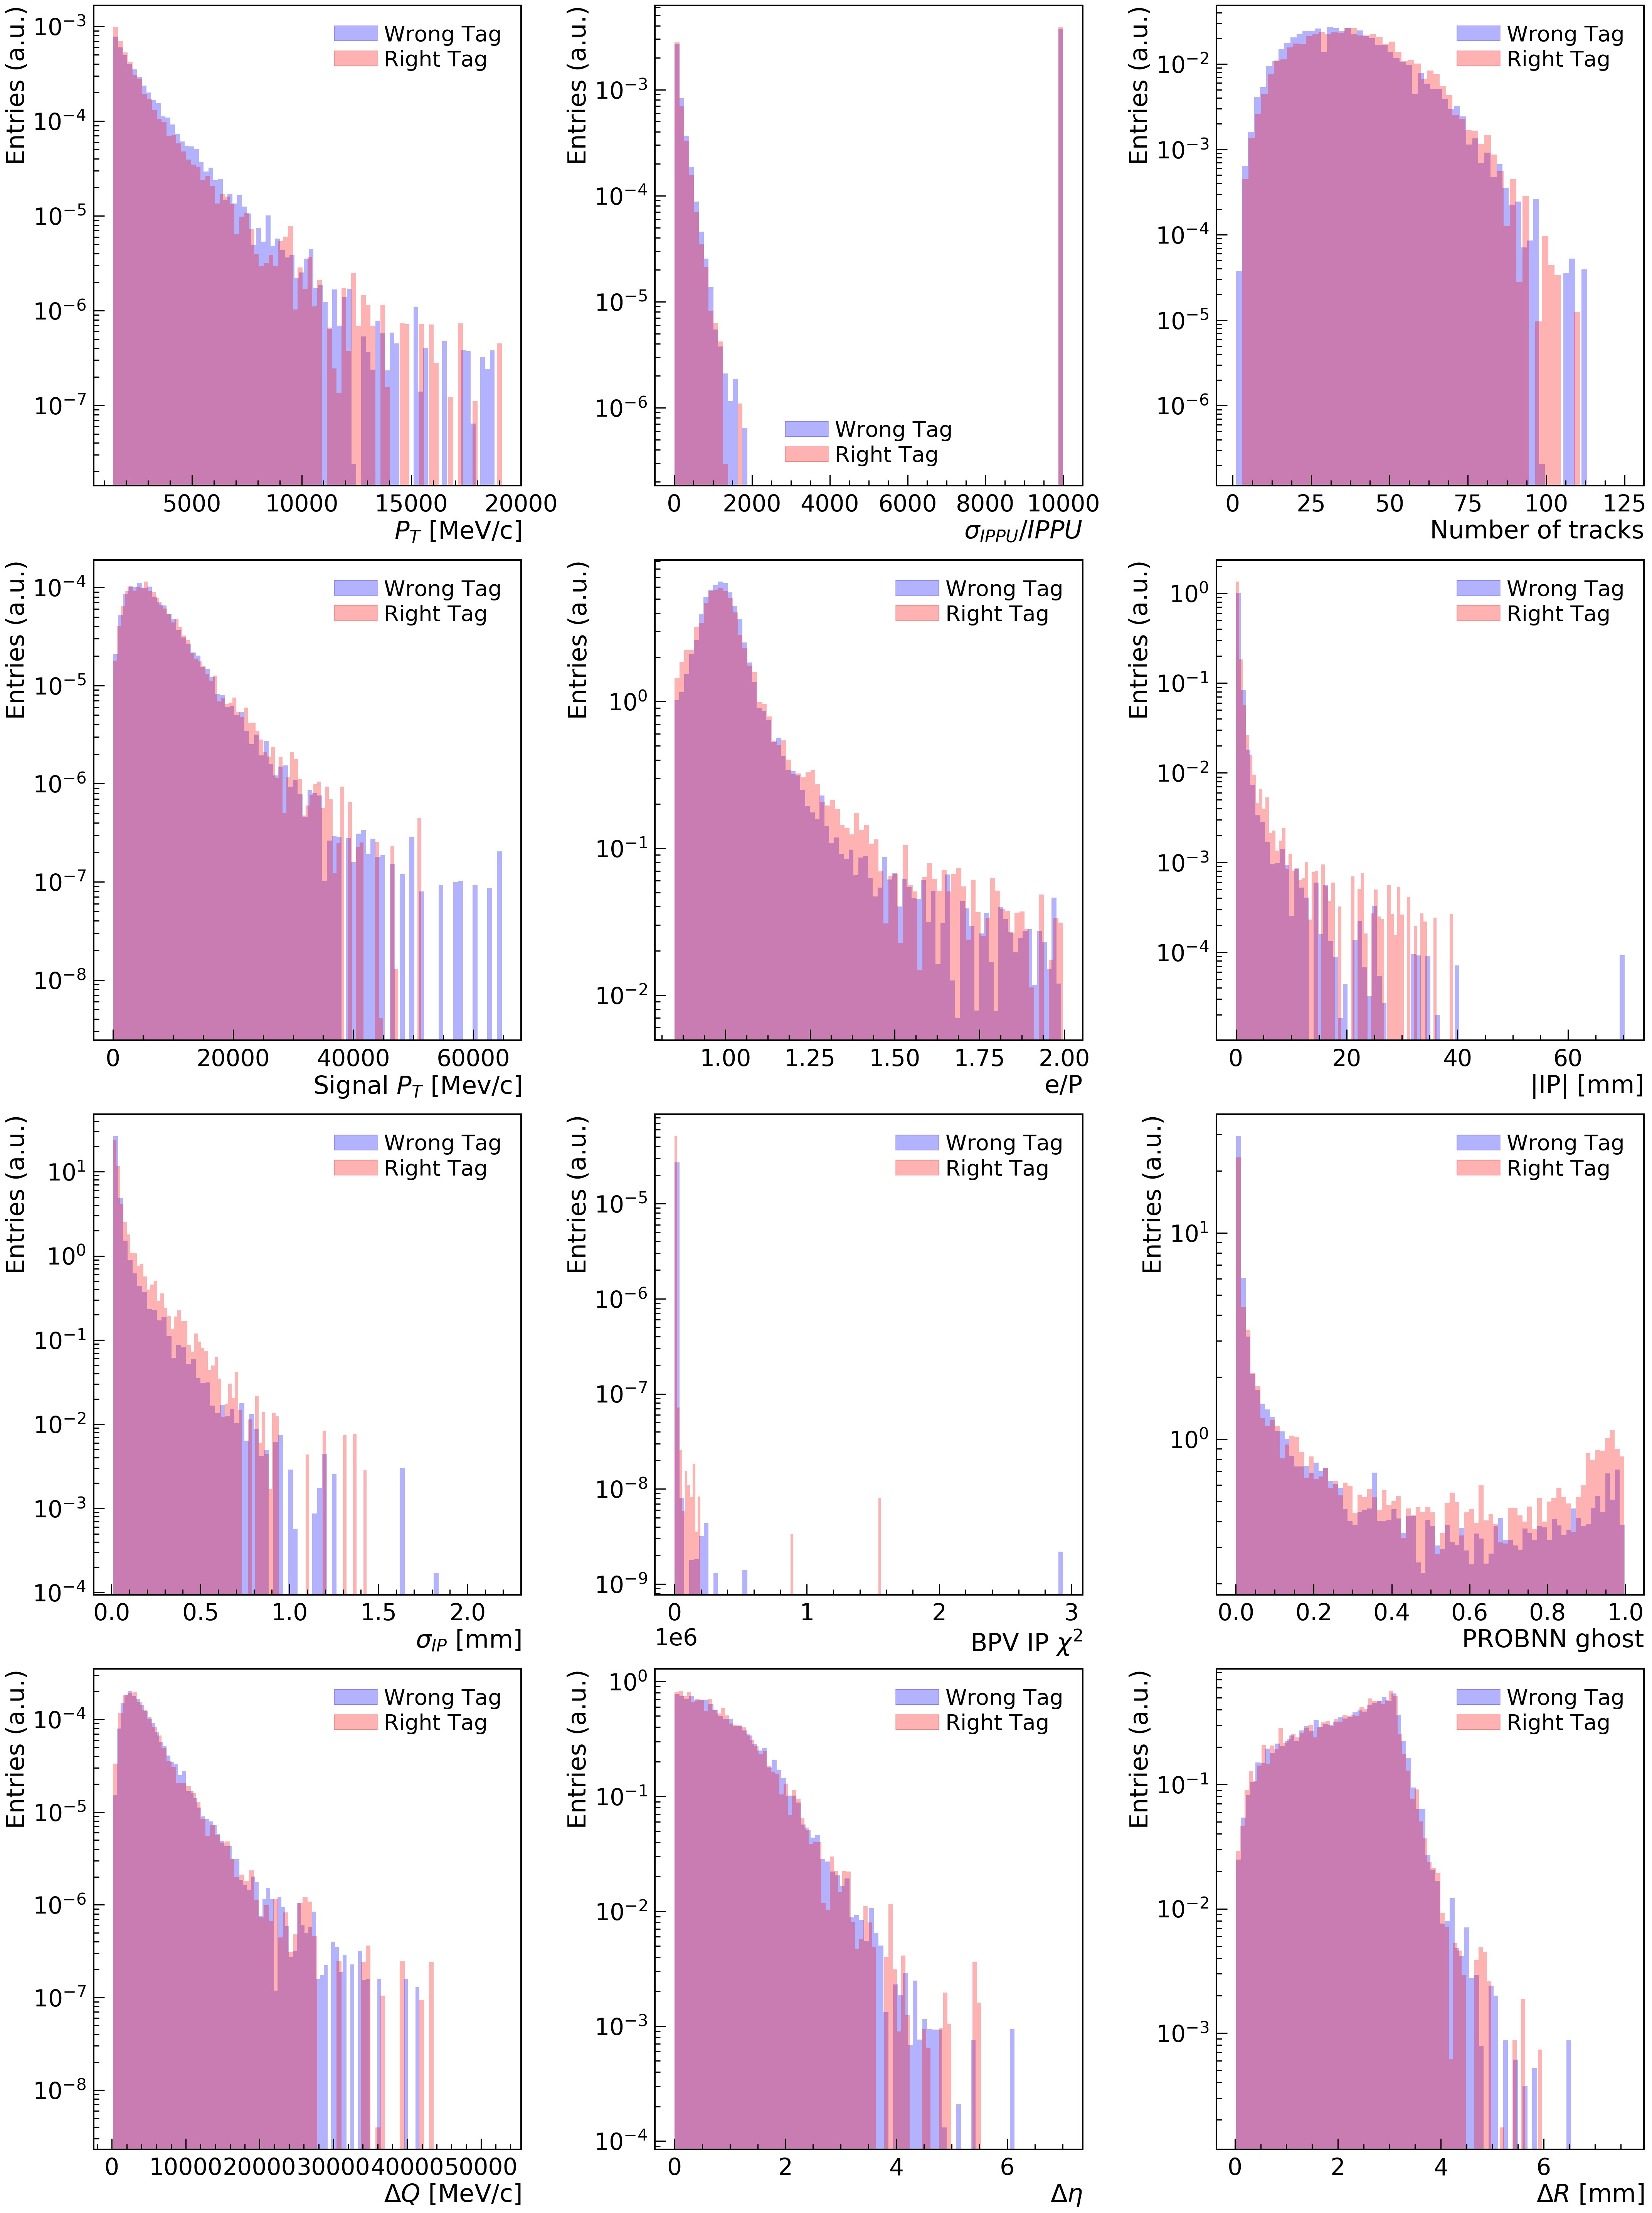

In [29]:
# compare wrong vs right tag distributions for all MVA features (Cuts optimized on Run2)
from plot_utils import plot_features
fig = plot_features(mva_dictionary, pd.concat([df_train_run2,df_eval1_run2,df_eval2_run2]), figsize=(30,40), columns=3)
#fig.show()
fig.savefig(fig_prefix + 'FeaturesDistribution_RunIIcuts.pdf')

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


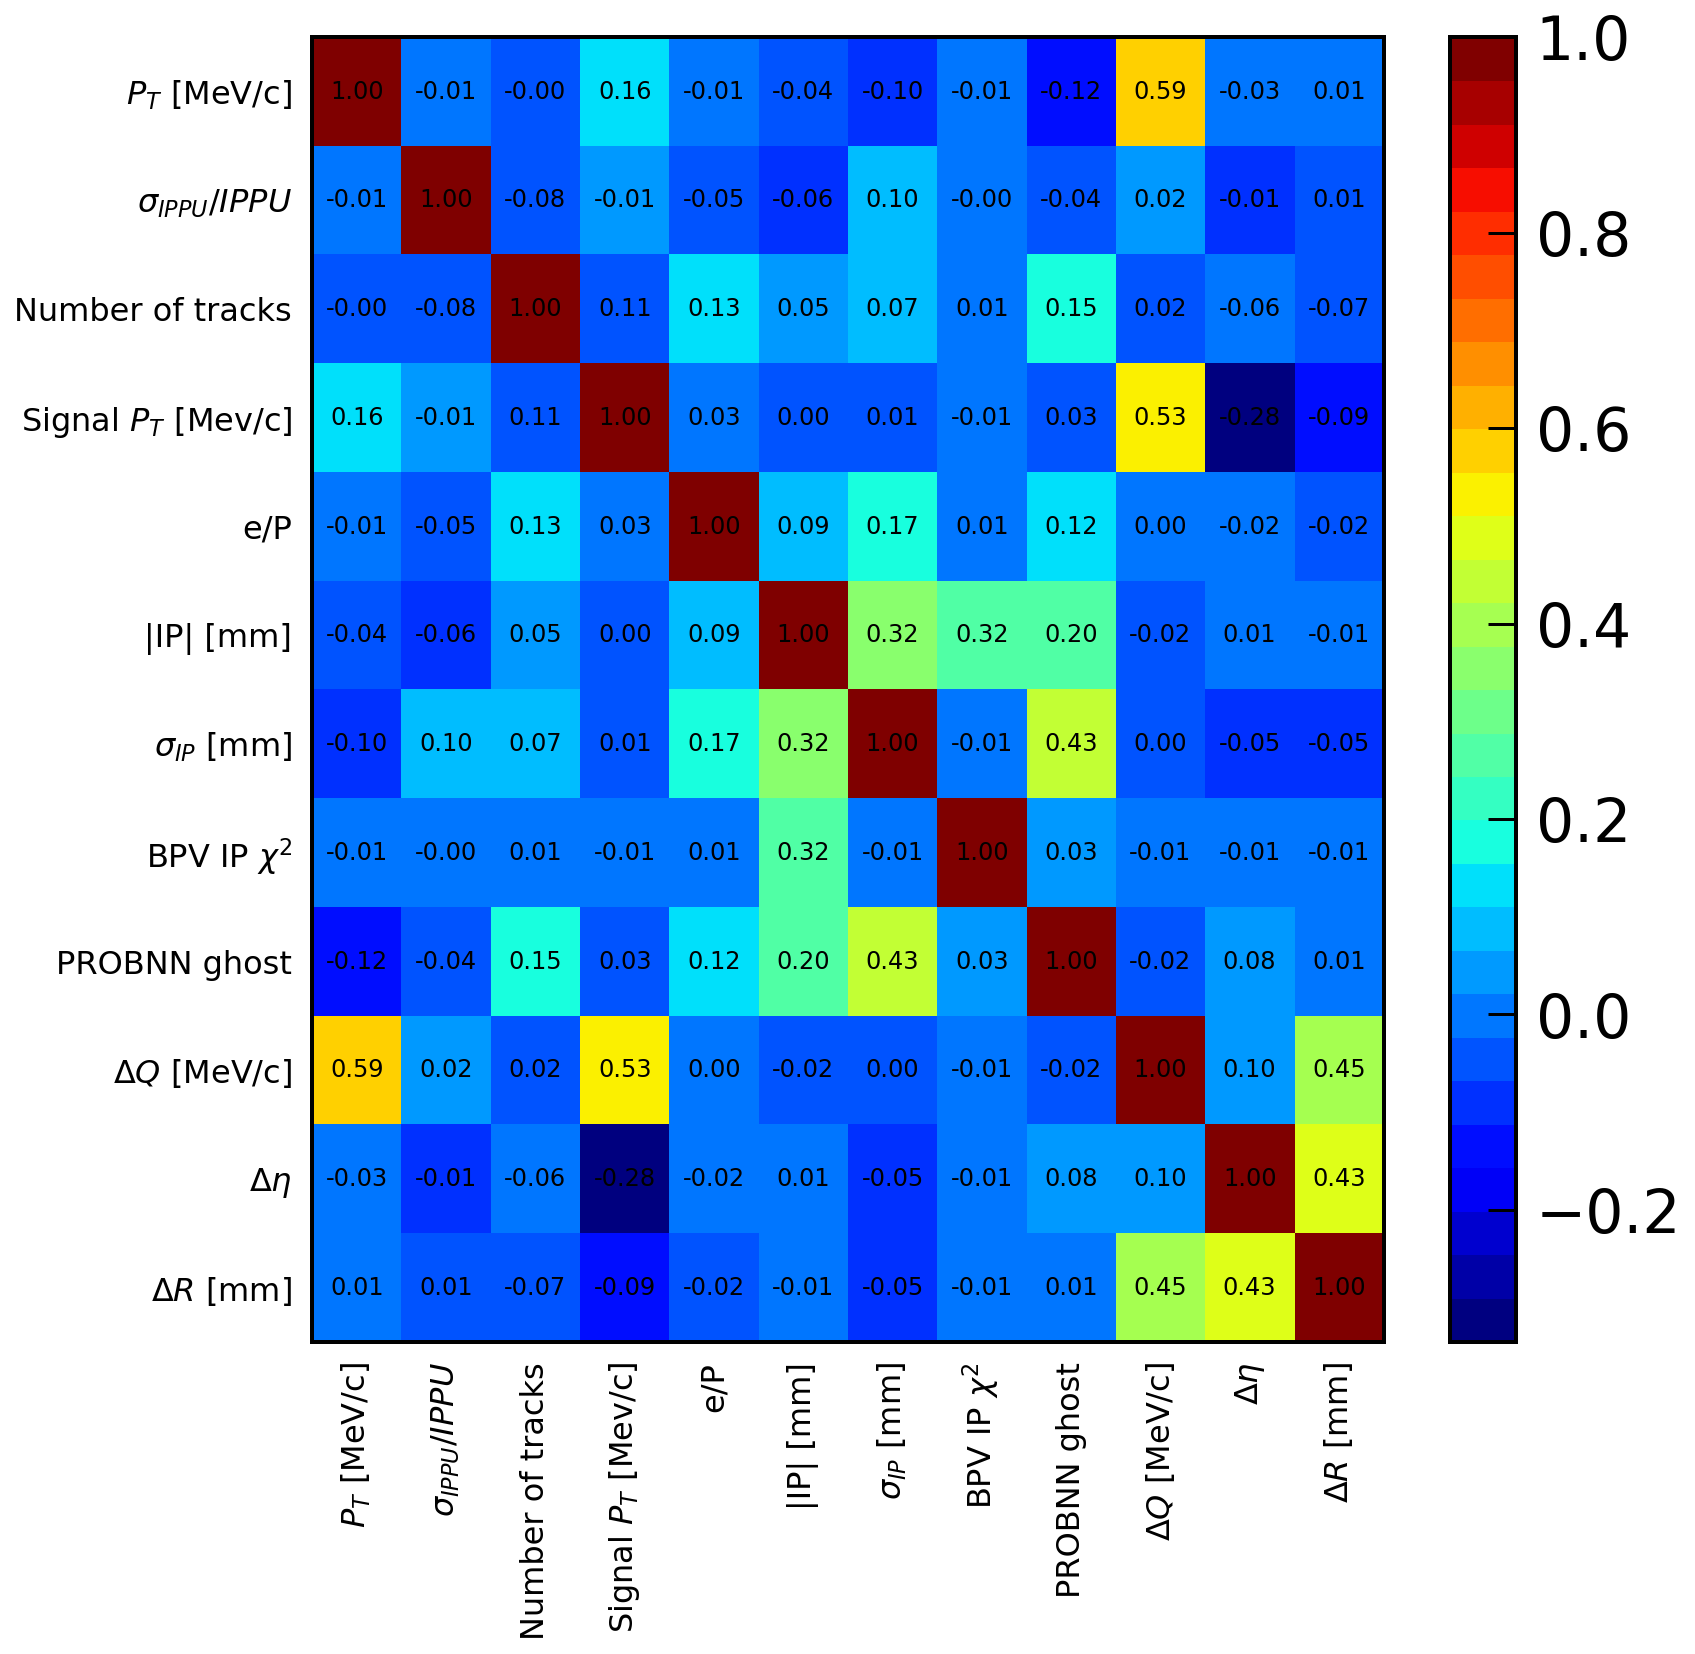

In [41]:
#Plot correlation matrix for right tagged candidates ("signal")
from plot_utils import plot_correlation
fig= plot_correlation(pd.concat([df_train_run2,df_eval1_run2,df_eval2_run2]).query('target==1'),
                      mva_dictionary)
fig.savefig(fig_prefix + 'FeaturesCorrRightTag_RunIIcuts.pdf')

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


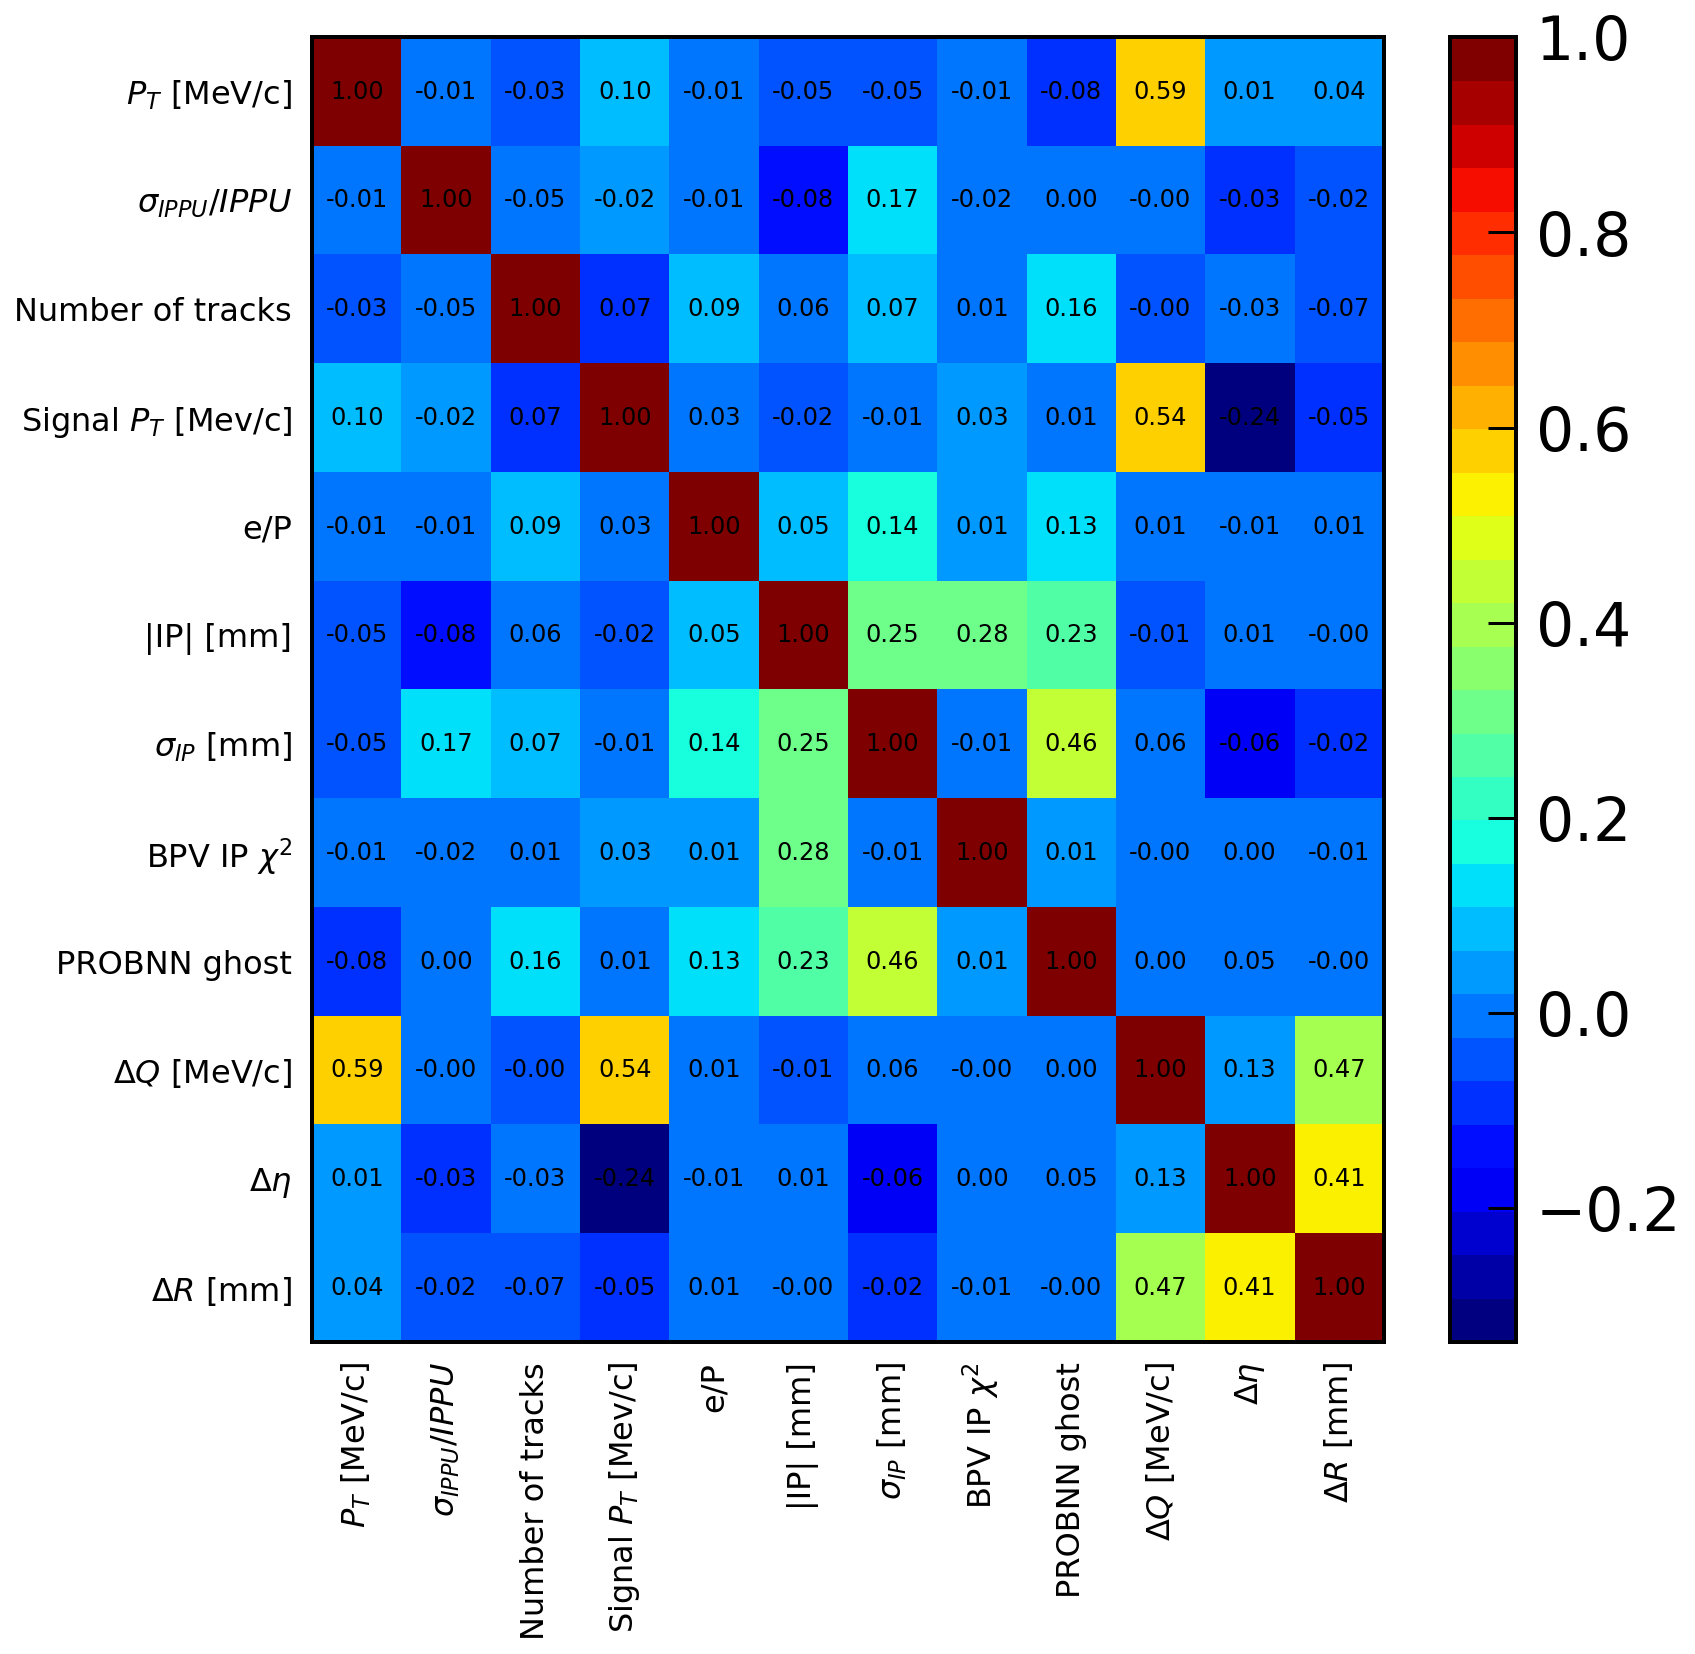

In [42]:
#Plot correlation matrix for wrong tagged candidates ("background")
fig= plot_correlation(pd.concat([df_train_run2,df_eval1_run2,df_eval2_run2]).query('target==0'),
                      mva_dictionary)
fig.savefig(fig_prefix + 'FeaturesCorrWrongTag_RunIIcuts.pdf')

In [9]:
X_train_run2, y_train_run2 = df_train_run2[list(mva_dictionary['Features'].keys())], df_train_run2.target
X_eval1_run2, y_eval1_run2 = df_eval1_run2[list(mva_dictionary['Features'].keys())], df_eval1_run2.target
X_eval2_run2, y_eval2_run2 = df_eval2_run2[list(mva_dictionary['Features'].keys())], df_eval2_run2.target
X_merged_run2, y_merged_run2 = df_merged_run2[list(mva_dictionary['Features'].keys())], df_merged_run2.target

In [10]:
#Do nominal training!
classifier_run2 = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=300, nthread=24, seed=42)

In [11]:
classifier_run2.fit(X_train_run2, y_train_run2, sample_weight=df_train_run2.SigYield_sw)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=24,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [12]:
#Dump run2 model
classifier_run2.booster().dump_model(weights_prefix + 'OSElectron_Data_Run2_All_Bu2JpsiK_XGB_BDT_v2r0.xgb')

In [13]:
# store the raw predictions, as well as the tag decisions
# (for the b → c → s → lepton transition, this is the positive sign of the PDG id)
pd.options.mode.chained_assignment = None

df_train_run2['probas'] = classifier_run2.predict_proba(X_train_run2)[:, 1]
df_train_run2['decisions'] = np.sign(df_train_run2.B_OSMuonDev_TagPartsFeature_ID)
df_eval1_run2['probas'] = classifier_run2.predict_proba(X_eval1_run2)[:, 1]
df_eval1_run2['decisions'] = np.sign(df_eval1_run2.B_OSMuonDev_TagPartsFeature_ID)
df_eval2_run2['probas'] = classifier_run2.predict_proba(X_eval2_run2)[:, 1]
df_eval2_run2['decisions'] = np.sign(df_eval2_run2.B_OSMuonDev_TagPartsFeature_ID)
df_merged_run2['probas'] = classifier_run2.predict_proba(X_merged_run2)[:, 1]
df_merged_run2['decisions'] = np.sign(df_merged_run2.B_OSMuonDev_TagPartsFeature_ID)

../../python/plot_utils.py:705: RuntimeWarning: invalid value encountered in sqrt
  yerrs = np.sqrt(histvals)
/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


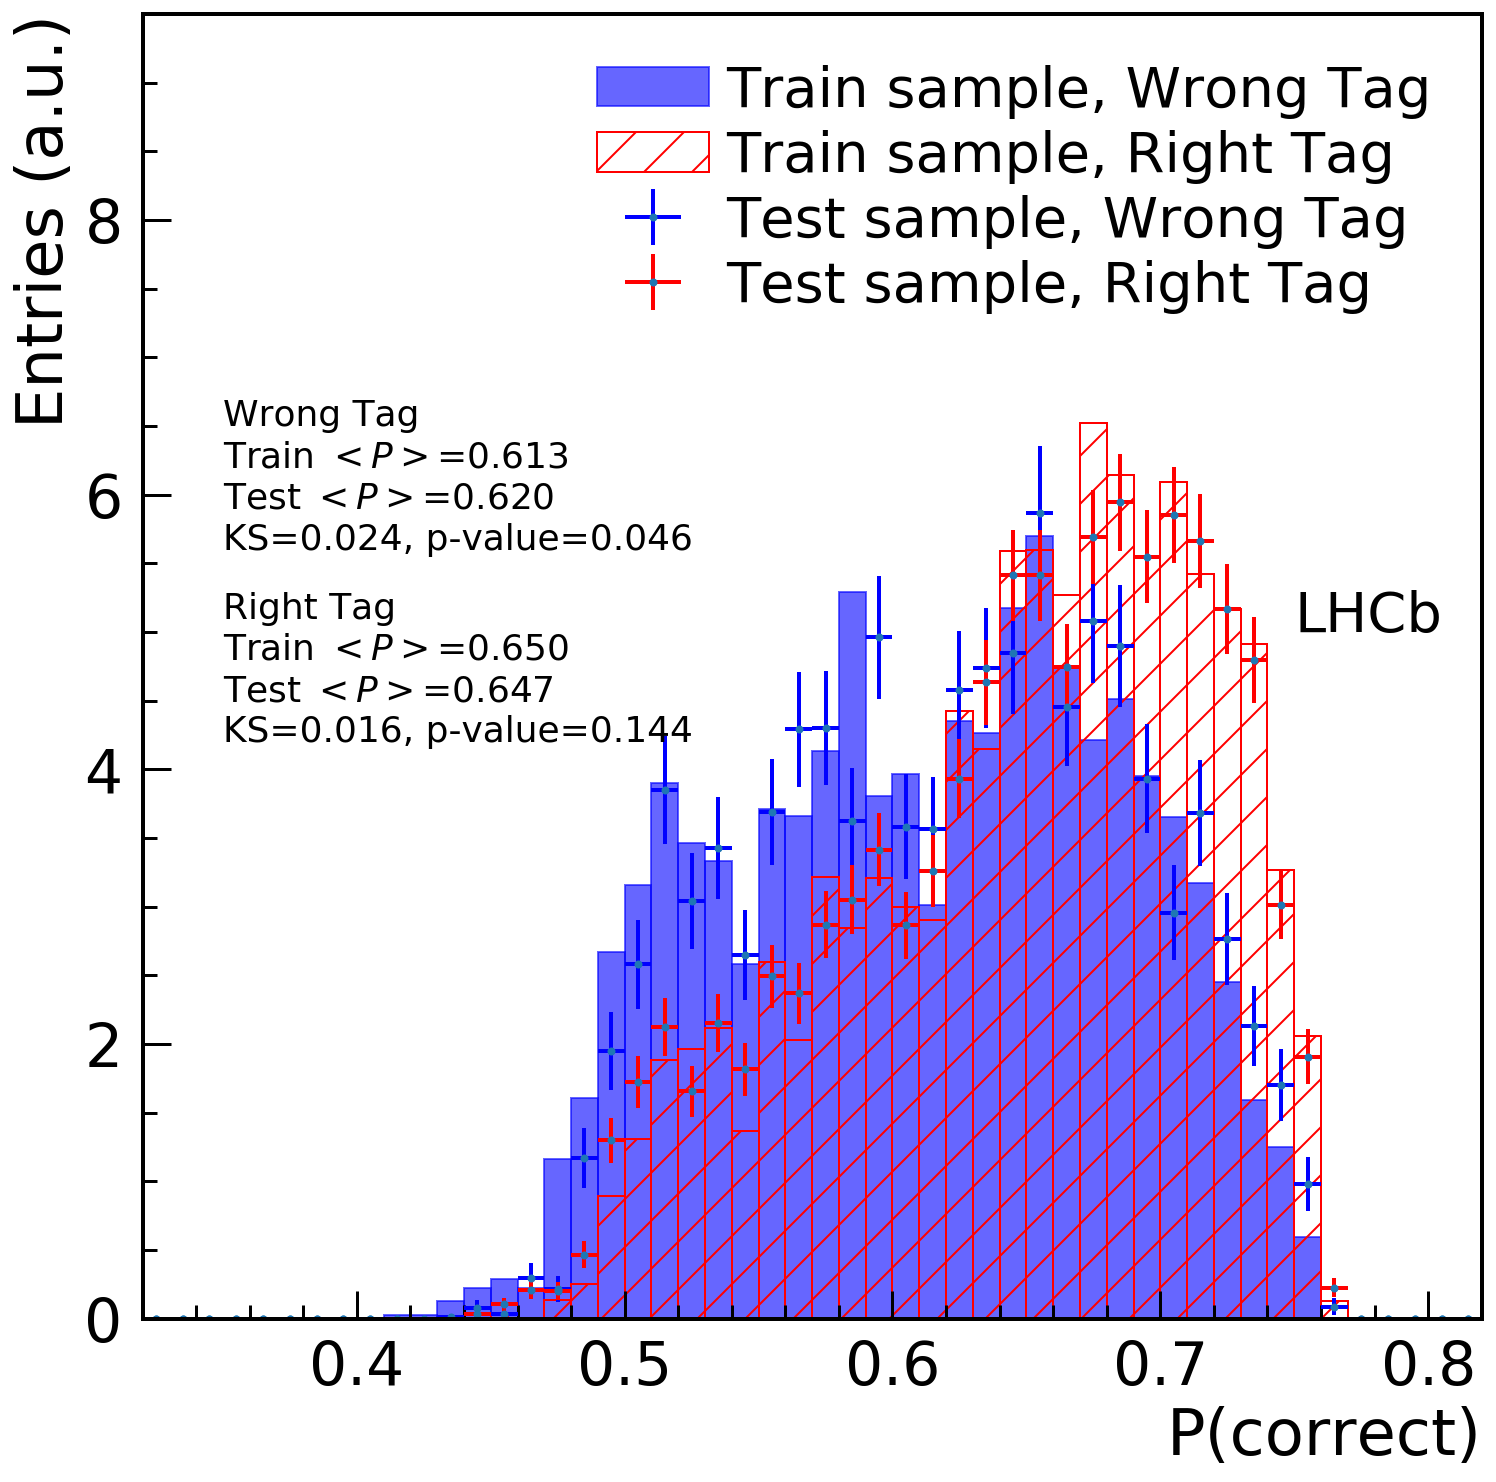

In [14]:
from plot_utils import plot_classifier_output
fig = plot_classifier_output(df_train_run2, 
                       df_merged_run2, 
                       type="probas",
                       ks_dict = {'x':0.35, 'y':6.5},
                       target_dict = mva_dictionary['Target'],
                       xrange=(0.32,0.82),
                       yrange=(0.0,9.5),
                       title="",
                       lhcb_label = {                                                                                                                                                         
                          'x'     : 0.75,                                                                                                                                                        
                          'y'     : 5,                                                                                                                                                        
                          'label' : 'LHCb',                                                                                                                                                   
                          'size'  : 28})
fig.savefig(fig_prefix + 'PredictedProba_RunIIcuts.pdf')
#fig.show()

In [14]:
# transform raw BDT to etas, and flip the tag
df_train_run2['etas'] = np.where(df_train_run2.probas > 0.5, 1 - df_train_run2.probas, df_train_run2.probas)
df_train_run2['decisions_flipped'] = np.where(df_train_run2.probas > 0.5, df_train_run2.decisions, -df_train_run2.decisions)
df_eval1_run2['etas'] = np.where(df_eval1_run2.probas > 0.5, 1 - df_eval1_run2.probas, df_eval1_run2.probas)
df_eval1_run2['decisions_flipped'] = np.where(df_eval1_run2.probas > 0.5, df_eval1_run2.decisions, -df_eval1_run2.decisions)
df_eval2_run2['etas'] = np.where(df_eval2_run2.probas > 0.5, 1 - df_eval2_run2.probas, df_eval2_run2.probas)
df_eval2_run2['decisions_flipped'] = np.where(df_eval2_run2.probas > 0.5, df_eval2_run2.decisions, -df_eval2_run2.decisions)
df_merged_run2['etas'] = np.where(df_merged_run2.probas > 0.5, 1 - df_merged_run2.probas, df_merged_run2.probas)
df_merged_run2['decisions_flipped'] = np.where(df_merged_run2.probas > 0.5, df_merged_run2.decisions, -df_merged_run2.decisions)

print('Fraction of flipped events:')
print('Run2 cuts, train sample {:.3f}%'.format( float((df_train_run2.probas > 0.5).sum()) / float(len(df_train_run2)) ))
print('Run2 cuts, eval1 sample {:.3f}%'.format( float((df_eval1_run2.probas > 0.5).sum()) / float(len(df_eval1_run2)) ))
print('Run2 cuts, eval2 sample {:.3f}%'.format( float((df_eval2_run2.probas > 0.5).sum()) / float(len(df_eval2_run2)) ))
print('Run2 cuts, non-training sample {:.3f}%'.format( float((df_merged_run2.probas > 0.5).sum()) / float(len(df_merged_run2)) ))

Fraction of flipped events:
Run2 cuts, train sample 0.955%
Run2 cuts, eval1 sample 0.953%
Run2 cuts, eval2 sample 0.955%
Run2 cuts, non-training sample 0.954%


In [15]:
# check for outliers (we must have omega<0.5 always, in principle)
df_wrong_train_run2 = df_train_run2.query('etas>0.5')
df_wrong_eval1_run2 = df_eval1_run2.query('etas>0.5')
df_wrong_eval2_run2 = df_eval2_run2.query('etas>0.5')
df_wrong_merged_run2 = df_merged_run2.query('etas>0.5')
print(len(df_wrong_train_run2))
print(len(df_wrong_eval1_run2))
print(len(df_wrong_eval2_run2))
print(len(df_wrong_merged_run2))

0
0
0
0


/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


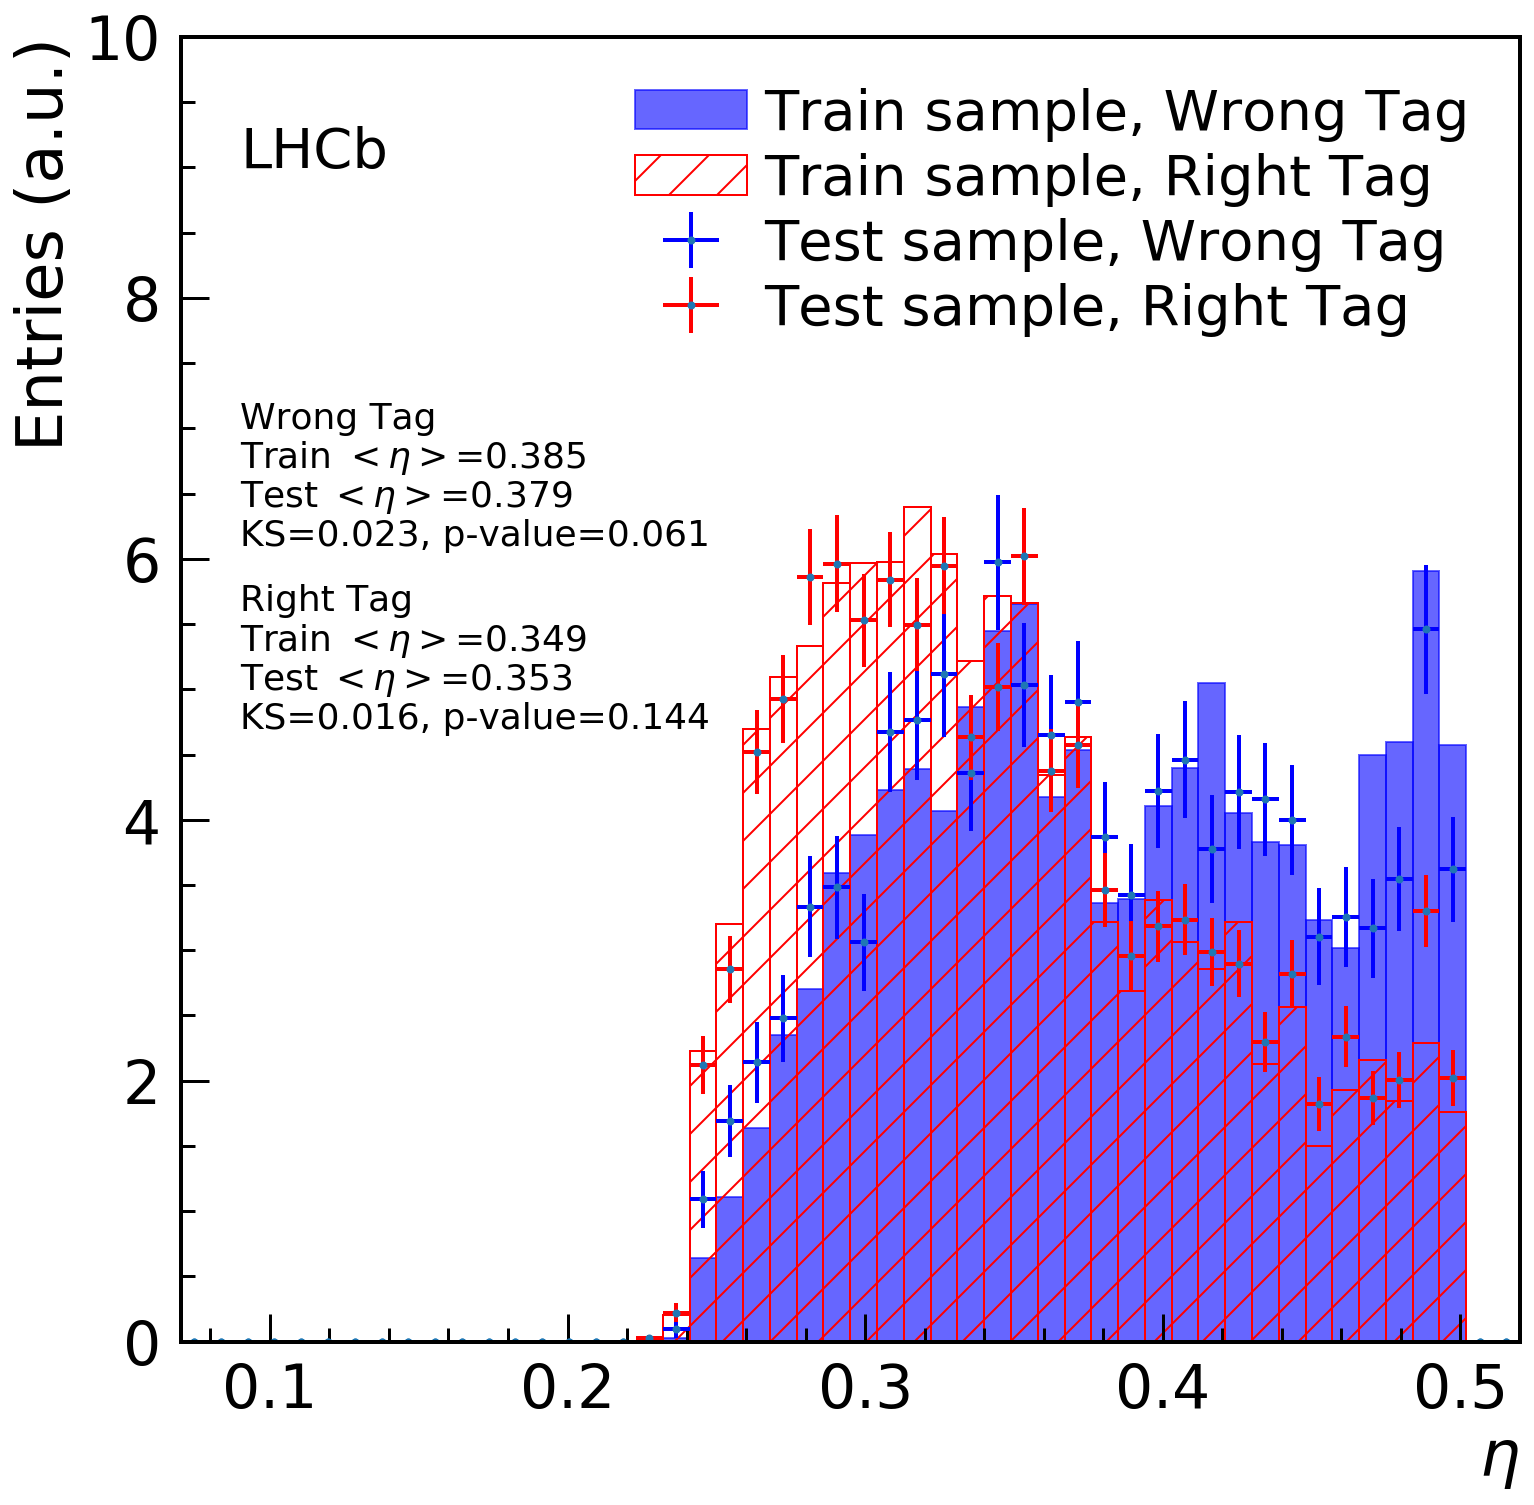

In [17]:
fig = plot_classifier_output(df_train_run2, 
                       df_merged_run2, 
                       type="etas",
                       ks_dict={'x':0.09, 'y':7.0},
                       target_dict = mva_dictionary['Target'],
                       xrange=(0.07,0.52),
                       yrange=(0., 10.),
                       title="",
                       lhcb_label = {                                                                                                                                                         
                          'x'     : 0.09,                                                                                                                                                        
                          'y'     : 9.,                                                                                                                                                        
                          'label' : 'LHCb',                                                                                                                                                   
                          'size'  : 28})
fig.savefig(fig_prefix + 'PredictedEta_RunIIcuts.pdf')
#fig.show()

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


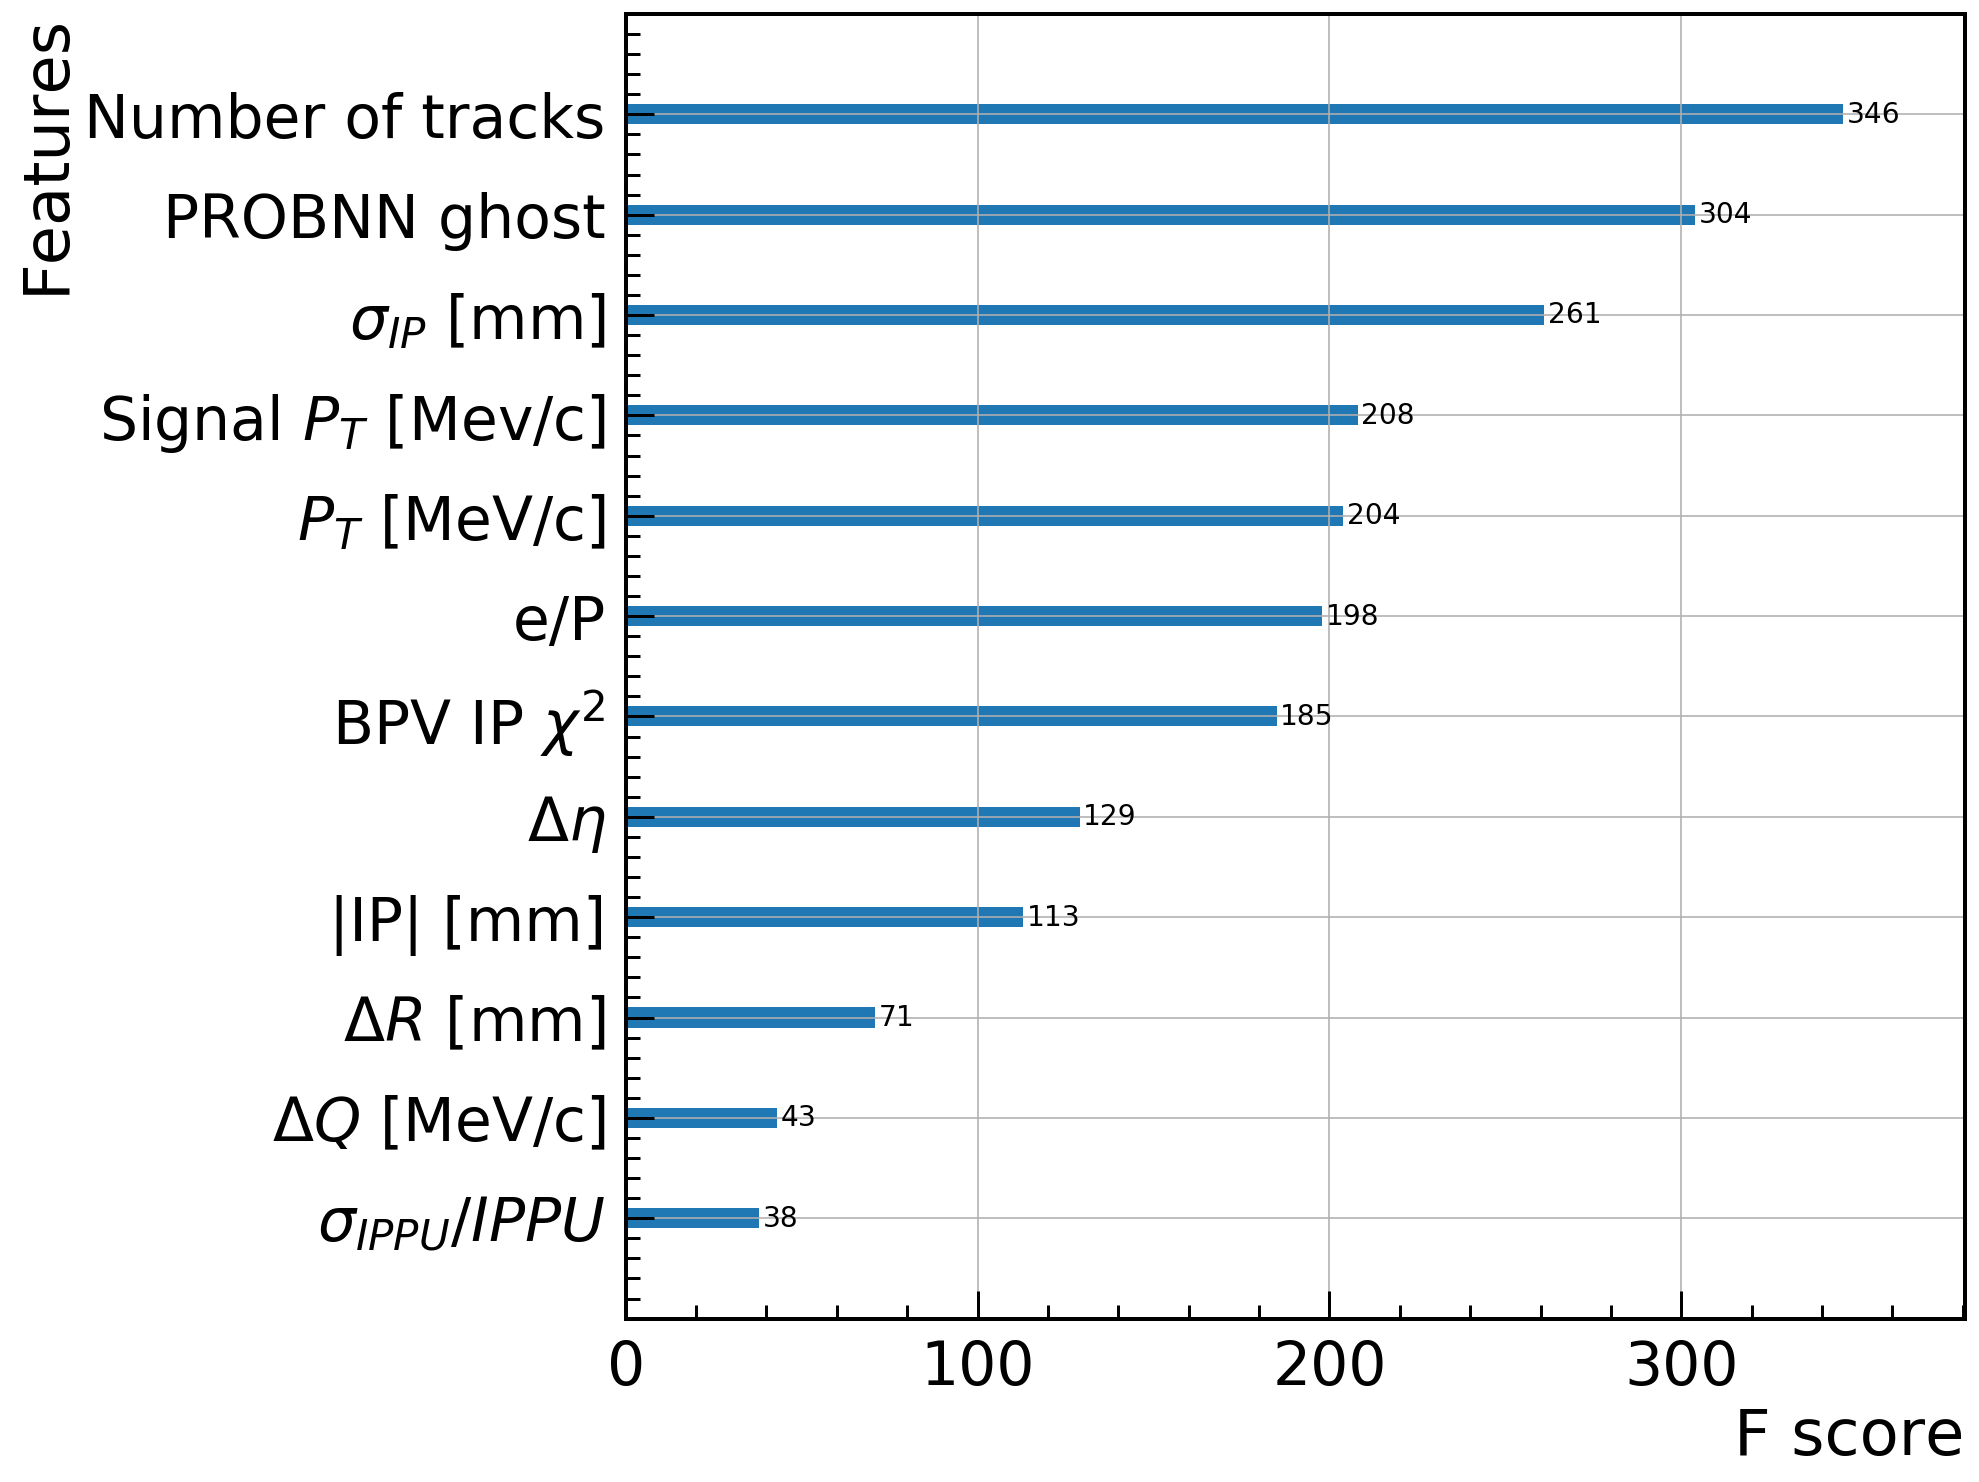

In [18]:
# check feature importance (Run2 cuts)
from plot_utils import plot_XGB_importance
fig = plot_XGB_importance(classifier_run2, 
                    mva_dictionary, 
                    title='');
fig.savefig(fig_prefix + 'Importance_RunIIcuts.pdf')
#fig.show()

INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_PT...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_IPPUSig...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_countTracks...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_Signal_PT...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_eOverP...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_AbsIP...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_IPErr...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_BPVIPCHI2...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_PROBNNghost_MC15TuneV1...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_DeltaQ...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_etaDistance...
INFO:plot_utils:Plotting B_OSMuonDev_TagPartsFeature_DeltaR...


/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


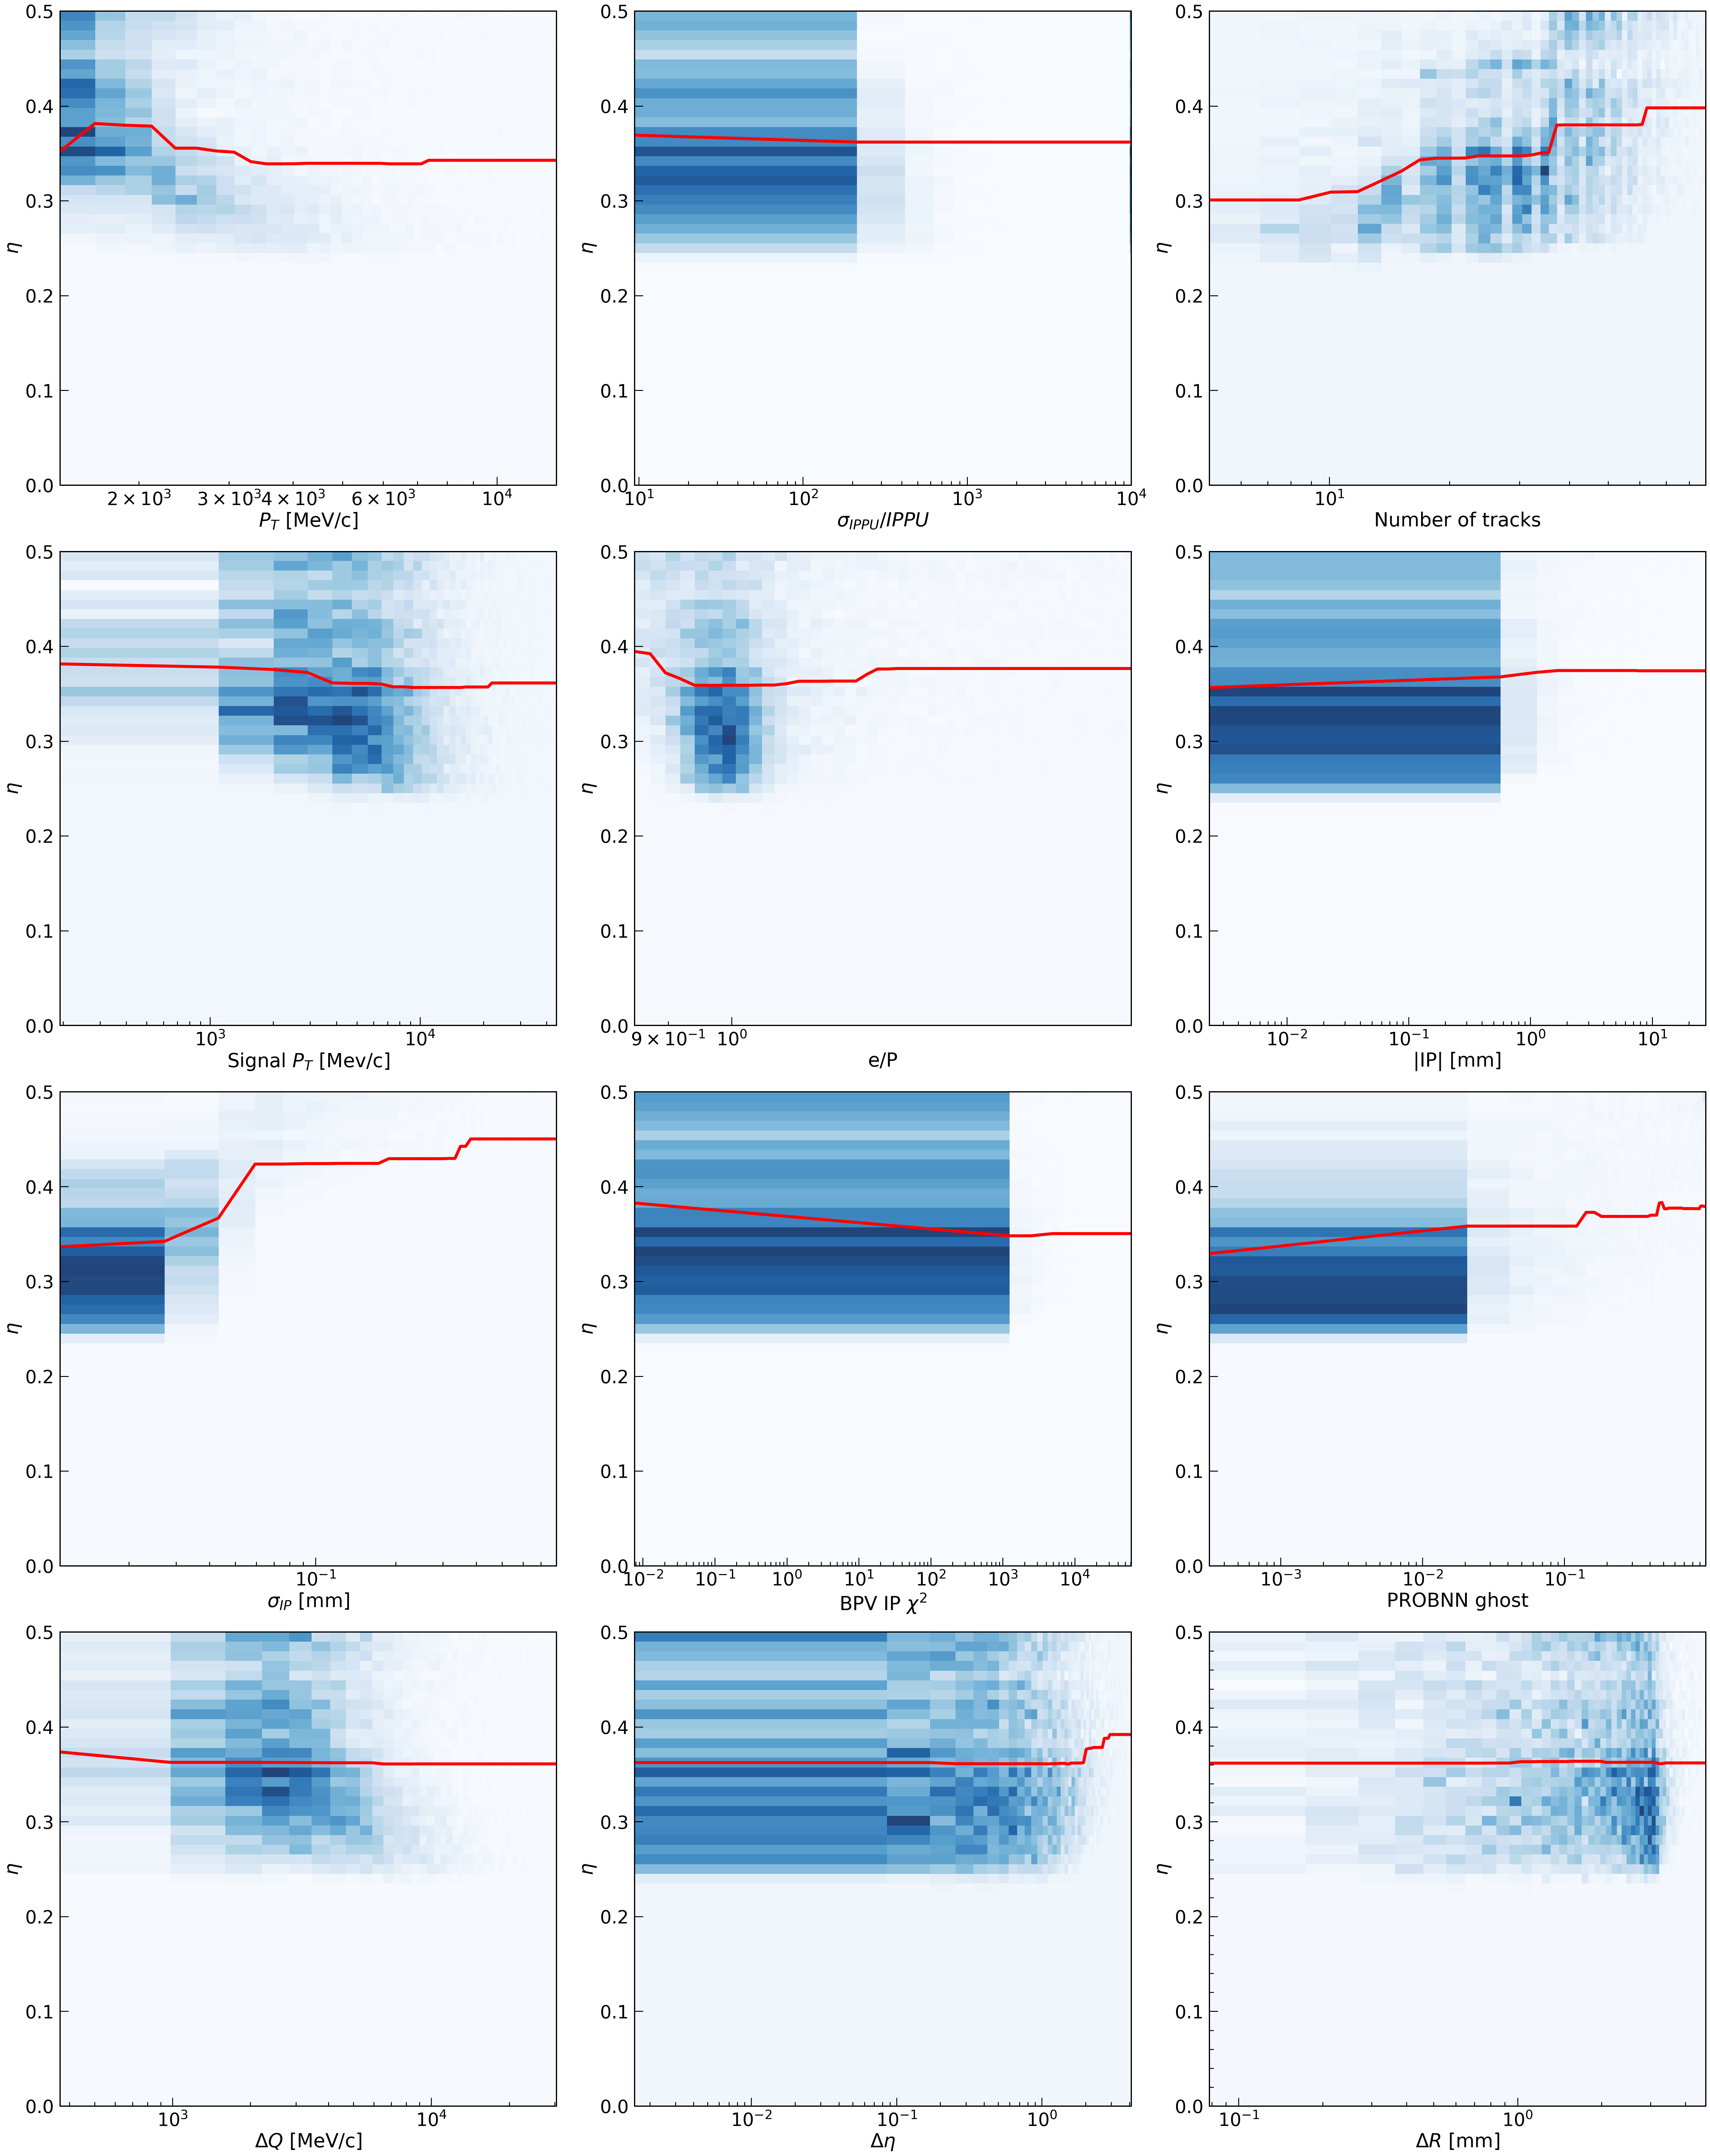

In [53]:
#plot partial dependency of eta over features
from plot_utils import plot_partial_dependency
fig = plot_partial_dependency(df_train_run2, 
                              classifier_run2, 
                              mva_dictionary,
                              df_train_run2['SigYield_sw'].values,
                              type="etas", columns=3, figsize=(40,50))
fig.savefig(fig_prefix + 'PartialDependence_RunIIcuts.pdf')
#fig.show()

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


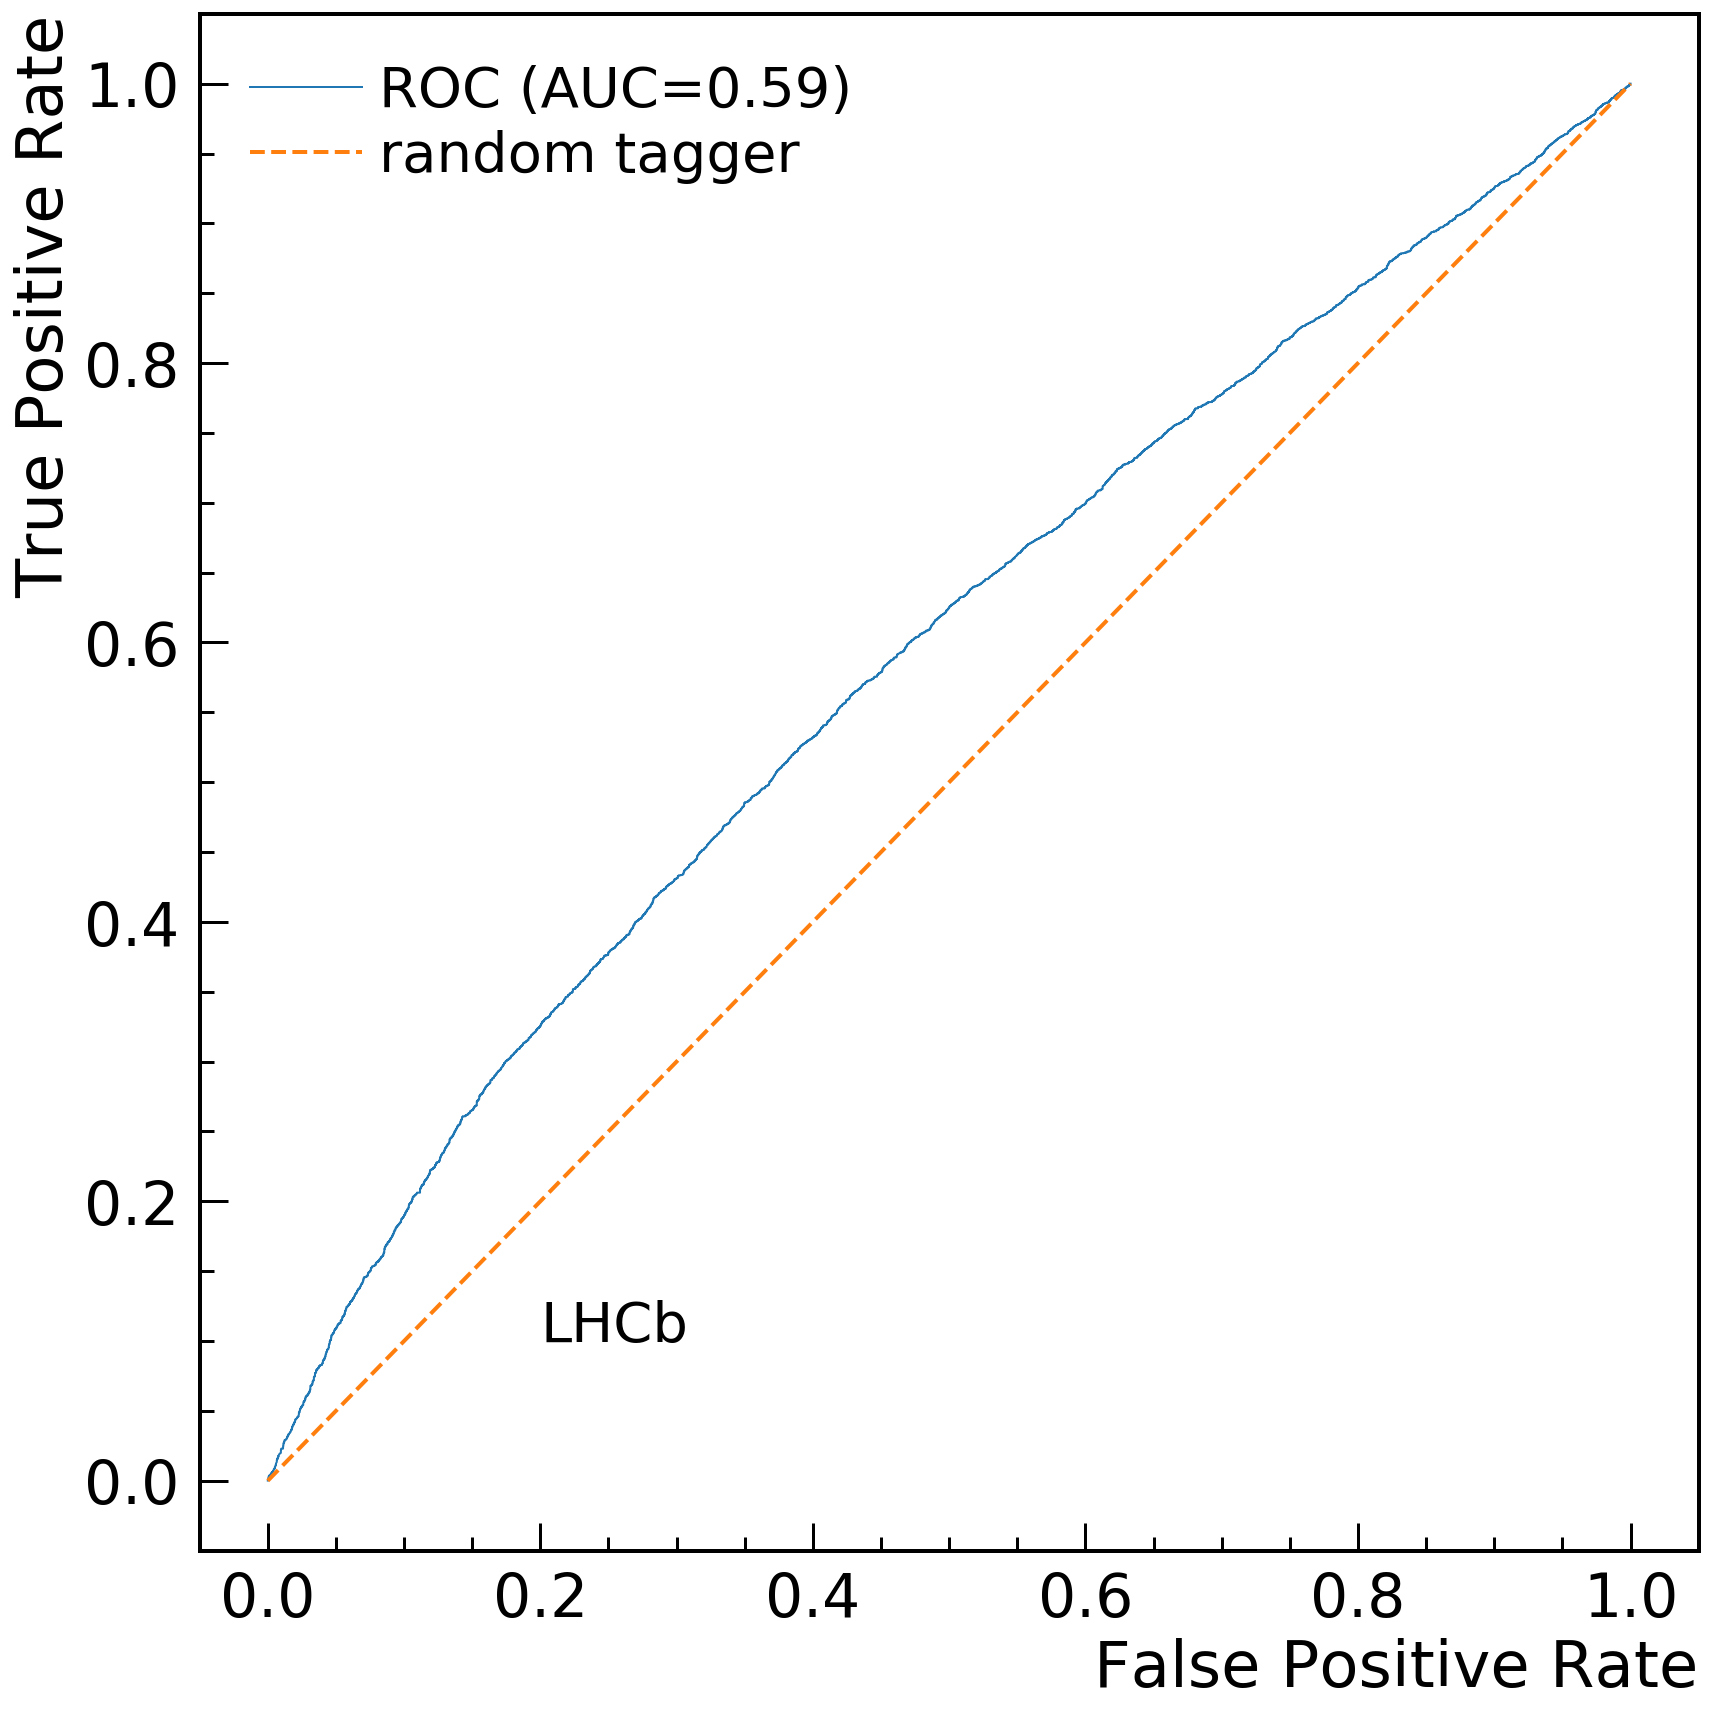

In [16]:
# check ROC on data (other than training set)
from plot_utils import plot_roc_auc
fig = plot_roc_auc(df_merged_run2, lhcb_label={"label":"LHCb", "size":28})
fig.savefig(fig_prefix + 'ROC_RunIIcuts.pdf')

In [17]:
# fit on eval1 sample, apply calibration on eval2 sample
from calib_models import PolynomialLogisticRegression

calibrationModel_run2 = PolynomialLogisticRegression(power=2, solver='lbfgs', n_jobs=24)
calibrationModel_run2.fit(df_eval1_run2.probas.values.reshape(-1, 1), df_eval1_run2.target, sample_weight=df_eval1_run2.SigYield_sw)
df_eval2_run2['calib_probas'] = calibrationModel_run2.predict_proba(df_eval2_run2.probas.values.reshape(-1, 1))[:,1]

In [18]:
# now get the calibrated etas (and flip the decisions)
df_eval2_run2['calib_etas'] = np.where(df_eval2_run2.calib_probas > 0.5, 1 - df_eval2_run2.calib_probas, df_eval2_run2.calib_probas)
df_eval2_run2['calib_decisions'] = np.where(df_eval2_run2.calib_probas > 0.5, df_eval2_run2.decisions, -df_eval2_run2.decisions)
print('Run2 cuts: flipped {:.3f}% of all events'.format(float((df_eval2_run2.calib_probas > 0.5).sum()) / float(len(df_eval2_run2))))

Run2 cuts: flipped 0.970% of all events


In [19]:
# check for outliers (we must have omega<0.5 always, in principle)
df_wrong_run2 = df_eval2_run2.query('calib_etas>0.5')
print(len(df_wrong_run2))

0


/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


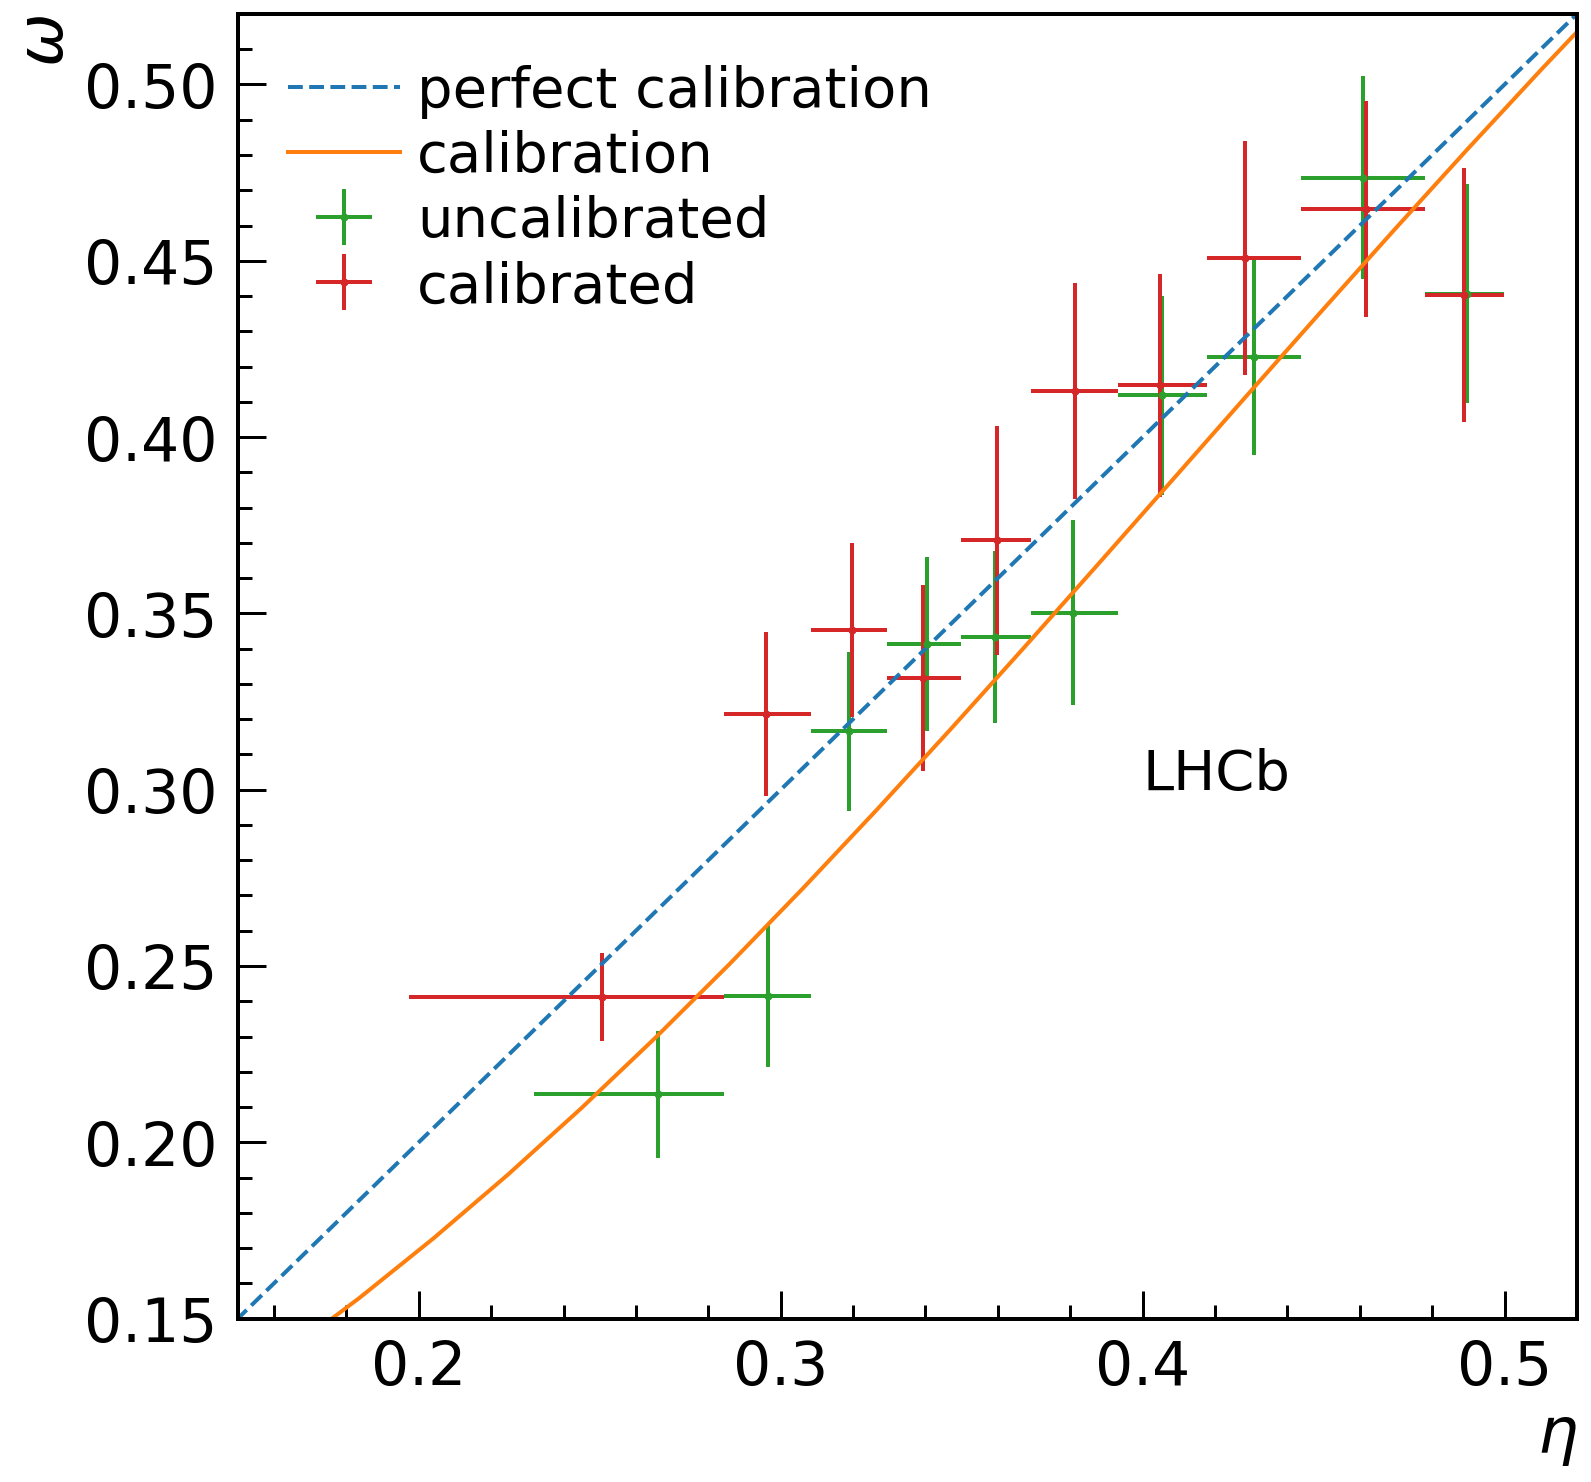

In [20]:
# plot calibrated mistag (Run2 cuts)
from plot_utils import plot_calib_curve
fig = plot_calib_curve(df_eval2_run2,
                 sample_weight=df_eval2_run2.SigYield_sw,
                 calib_model=calibrationModel_run2,
                 type='etas',
                 title='',
                 x_lim=[0.15, 0.52],
                 y_lim=[0.15, 0.52],
                 lhcb_label = {                                                                                                                                                         
                          'x'     : 0.4,                                                                                                                                                        
                          'y'     : 0.3,                                                                                                                                                        
                          'label' : 'LHCb',                                                                                                                                                   
                          'size'  : 28})
#fig.show()

In [21]:
# fit on eval2 sample, apply calibration on eval1 sample
from calib_models import PolynomialLogisticRegression

calibrationModel_run2 = PolynomialLogisticRegression(power=2, solver='lbfgs', n_jobs=24)
calibrationModel_run2.fit(df_eval2_run2.probas.values.reshape(-1, 1), df_eval2_run2.target, sample_weight=df_eval2_run2.SigYield_sw)
df_eval1_run2['calib_probas'] = calibrationModel_run2.predict_proba(df_eval1_run2.probas.values.reshape(-1, 1))[:,1]

In [22]:
# now get the calibrated etas (and flip the decisions)
df_eval1_run2['calib_etas'] = np.where(df_eval1_run2.calib_probas > 0.5, 1 - df_eval1_run2.calib_probas, df_eval1_run2.calib_probas)
df_eval1_run2['calib_decisions'] = np.where(df_eval1_run2.calib_probas > 0.5, df_eval1_run2.decisions, -df_eval1_run2.decisions)
print('Run2 cuts: flipped {:.3f}% of all events'.format(float((df_eval1_run2.calib_probas > 0.5).sum()) / float(len(df_eval1_run2))))

Run2 cuts: flipped 0.988% of all events


In [23]:
# check for outliers (we must have omega<0.5 always, in principle)
df_wrong_run2 = df_eval1_run2.query('calib_etas>0.5')
print(len(df_wrong_run2))

0


/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


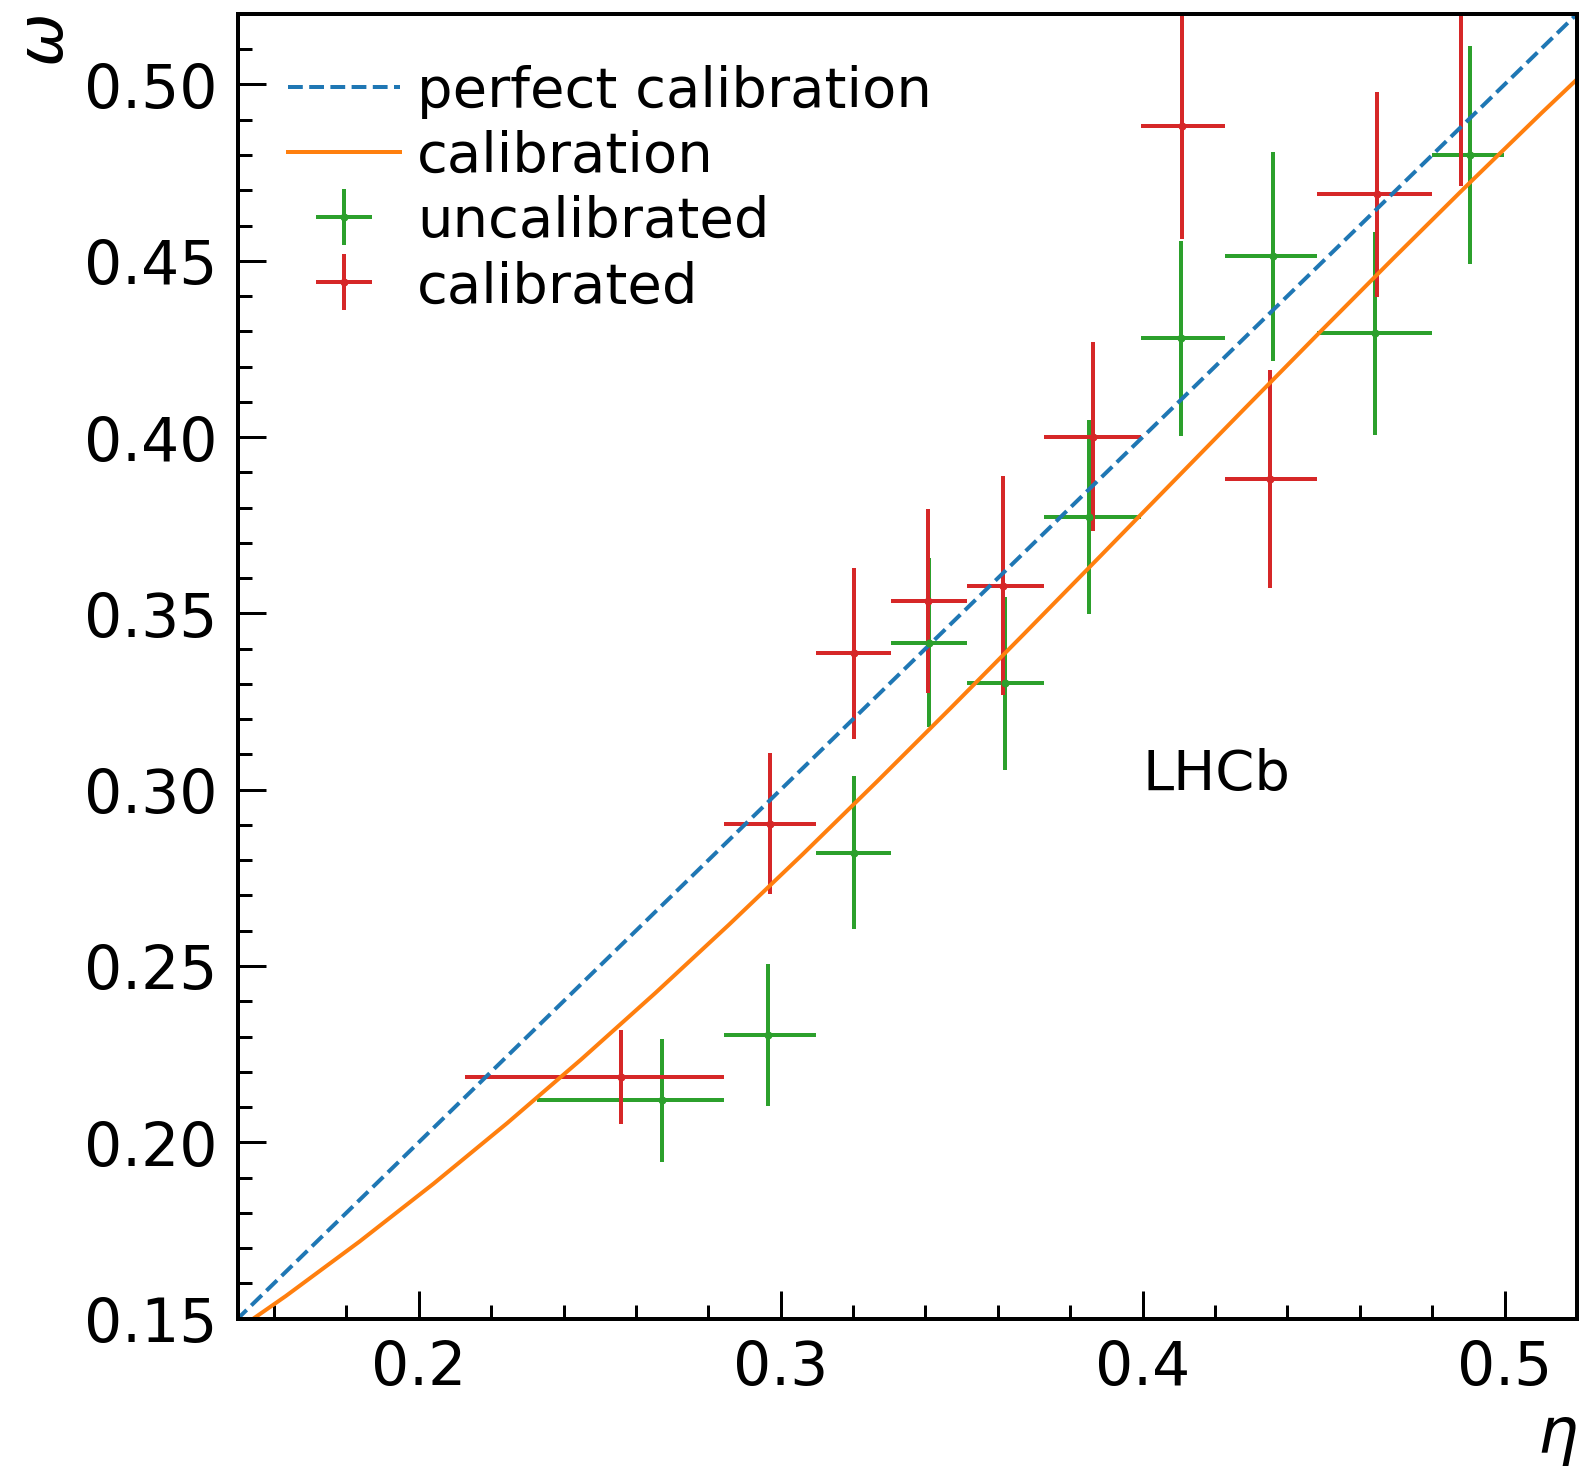

In [61]:
# plot calibrated mistag (Run2 cuts)
from plot_utils import plot_calib_curve
fig = plot_calib_curve(df_eval1_run2,
                 sample_weight=df_eval1_run2.SigYield_sw,
                 calib_model=calibrationModel_run2,
                 type='etas',
                 title='',
                 x_lim=[0.15, 0.52],
                 y_lim=[0.15, 0.52],
                 lhcb_label = {                                                                                                                                                         
                          'x'     : 0.4,                                                                                                                                                        
                          'y'     : 0.3,                                                                                                                                                        
                          'label' : 'LHCb',                                                                                                                                                   
                          'size'  : 28})
#fig.show()

In [24]:
# fit and calibrate on same sample
from calib_models import PolynomialLogisticRegression

calibrationModel_run2 = PolynomialLogisticRegression(power=2, solver='lbfgs', n_jobs=24)
calibrationModel_run2.fit(df_merged_run2.probas.values.reshape(-1, 1), df_merged_run2.target, sample_weight=df_merged_run2.SigYield_sw)
df_merged_run2['calib_probas'] = calibrationModel_run2.predict_proba(df_merged_run2.probas.values.reshape(-1, 1))[:,1]

In [25]:
# now get the calibrated etas (and flip the decisions)
df_merged_run2['calib_etas'] = np.where(df_merged_run2.calib_probas > 0.5, 1 - df_merged_run2.calib_probas, df_merged_run2.calib_probas)
df_merged_run2['calib_decisions'] = np.where(df_merged_run2.calib_probas > 0.5, df_merged_run2.decisions, -df_merged_run2.decisions)
print('Run2 cuts: flipped {:.3f}% of all events'.format(float((df_merged_run2.calib_probas > 0.5).sum()) / float(len(df_merged_run2))))

Run2 cuts: flipped 0.967% of all events


In [26]:
# check for outliers (we must have omega<0.5 always, in principle)
df_wrong_run2 = df_merged_run2.query('calib_etas>0.5')
print(len(df_wrong_run2))

0


/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


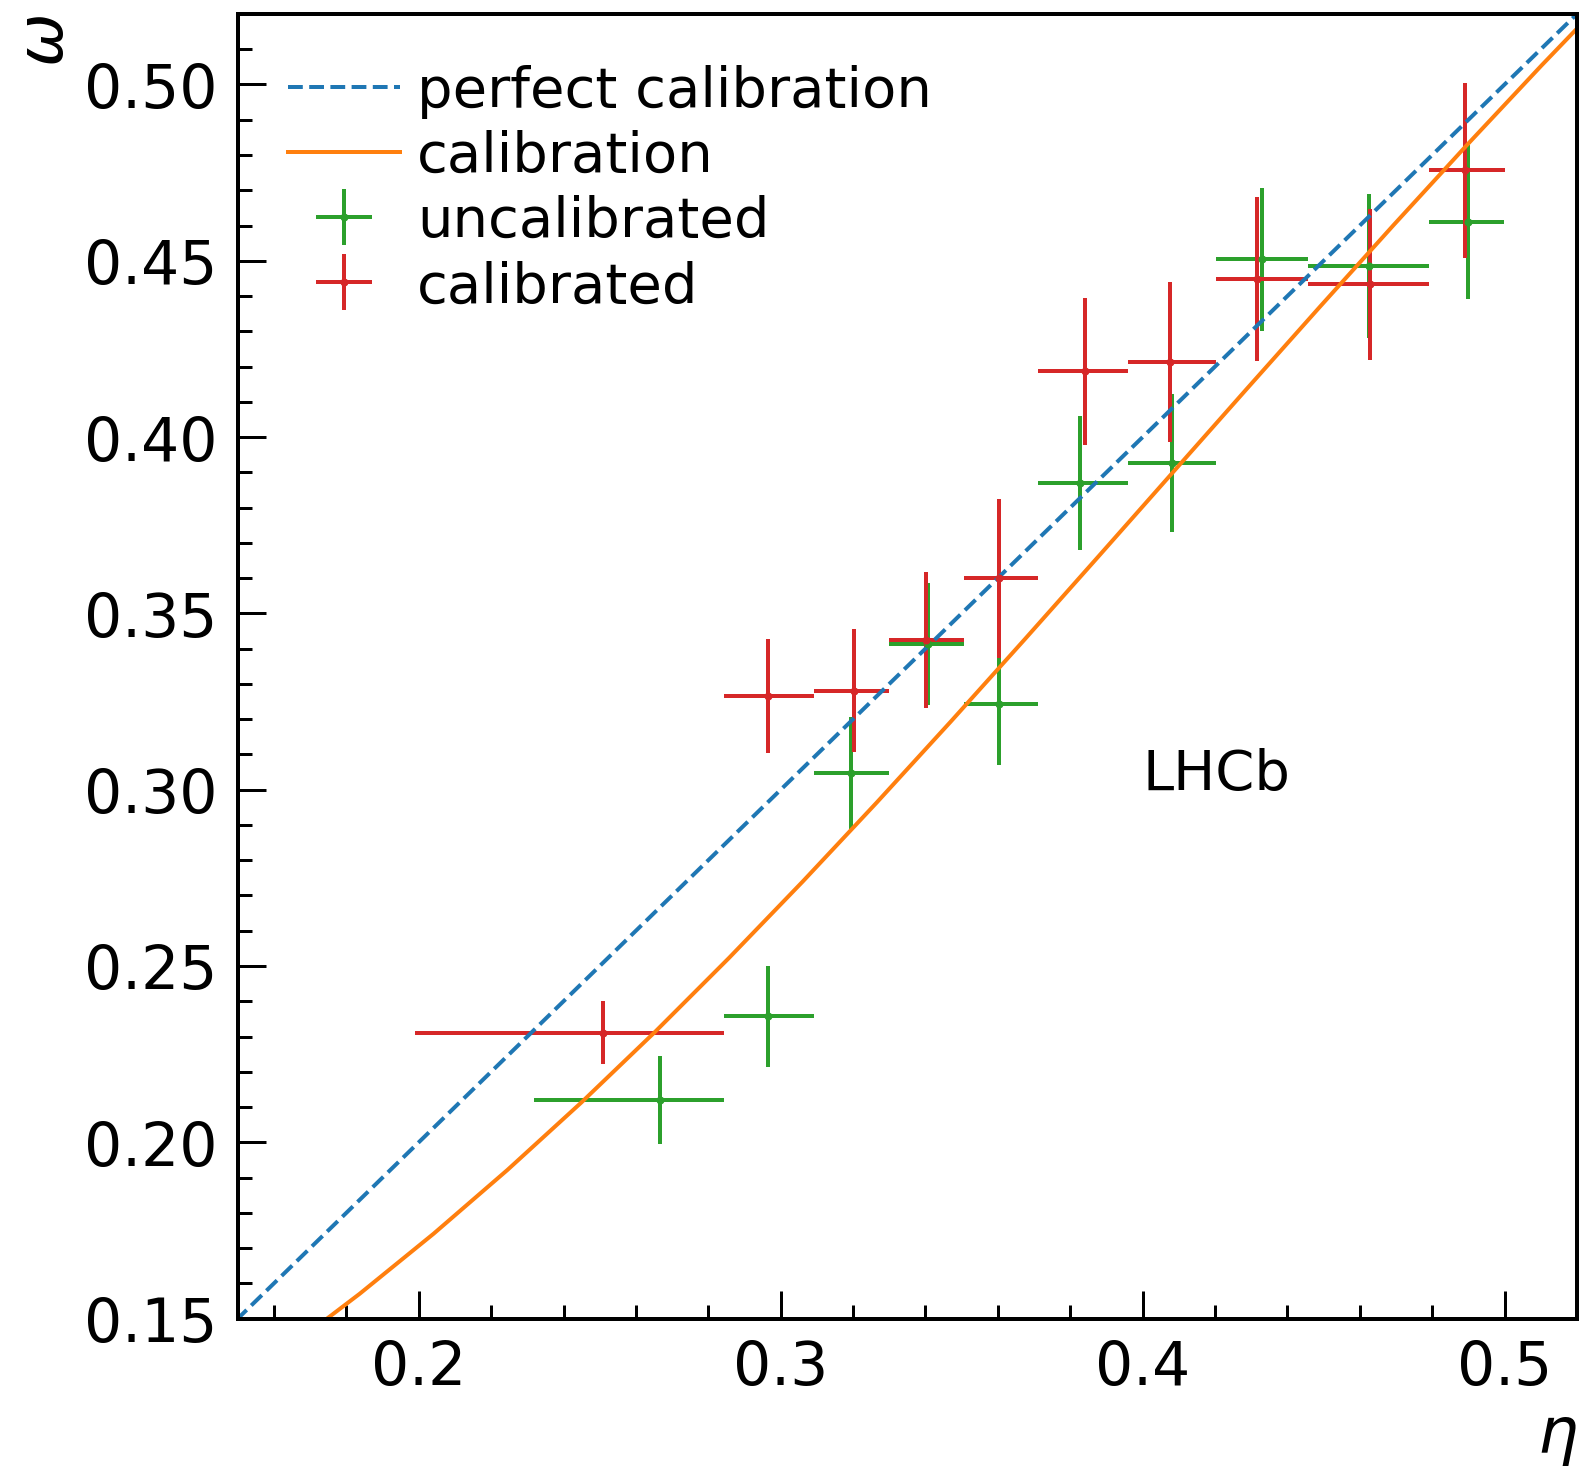

In [65]:
# plot calibrated mistag (Run2 cuts)
from plot_utils import plot_calib_curve
fig = plot_calib_curve(df_merged_run2,
                 sample_weight=df_merged_run2.SigYield_sw,
                 calib_model=calibrationModel_run2,
                 type='etas',
                 title='',
                 x_lim=[0.15, 0.52],
                 y_lim=[0.15, 0.52],
                 lhcb_label = {                                                                                                                                                         
                          'x'     : 0.4,                                                                                                                                                        
                          'y'     : 0.3,                                                                                                                                                        
                          'label' : 'LHCb',                                                                                                                                                   
                          'size'  : 28})
#fig.show()

# Evaluate calibrated performance

In [27]:
# first get the max-pt particles
max_pt_df_eval1_run2 = df_eval1_run2.loc[df_eval1_run2.groupby(['runNumber', 'eventNumber', 'nCandidate']).B_OSMuonDev_TagPartsFeature_PT.idxmax()]
max_pt_df_eval2_run2 = df_eval2_run2.loc[df_eval2_run2.groupby(['runNumber', 'eventNumber', 'nCandidate']).B_OSMuonDev_TagPartsFeature_PT.idxmax()]
max_pt_df_merged_run2 = df_merged_run2.loc[df_merged_run2.groupby(['runNumber', 'eventNumber', 'nCandidate']).B_OSMuonDev_TagPartsFeature_PT.idxmax()]

In [28]:
tp_eval1 = (max_pt_df_eval1_run2.SigYield_sw * (1 - 2 * max_pt_df_eval1_run2.calib_etas)**2).sum() / eval1_event_number_run2 
tp_eval1_err = np.sqrt(tp_eval1 * (1 - tp_eval1) * eval1_event_number_run2) / eval1_event_number_run2 
print("Tagging power on 'eval1' sample: ε_eff = {:.3f}+/-{:.3f}%".format(tp_eval1*100, tp_eval1_err*100))

tp_eval2 = (max_pt_df_eval2_run2.SigYield_sw * (1 - 2 * max_pt_df_eval2_run2.calib_etas)**2).sum() / eval2_event_number_run2 
tp_eval2_err = np.sqrt(tp_eval2 * (1 - tp_eval2) * eval2_event_number_run2) / eval2_event_number_run2 
print("Tagging power on 'eval2' sample: ε_eff = {:.3f}+/-{:.3f}%".format(tp_eval2*100, tp_eval2_err*100))

tp_merged = (max_pt_df_merged_run2.SigYield_sw * (1 - 2 * max_pt_df_merged_run2.calib_etas)**2).sum() / merged_event_number_run2 
tp_merged_err = np.sqrt(tp_merged * (1 - tp_merged) * merged_event_number_run2) / merged_event_number_run2 
print("Tagging power on 'merged' sample: ε_eff = {:.3f}+/-{:.3f}%".format(tp_merged*100, tp_merged_err*100))

Tagging power on 'eval1' sample: ε_eff = 0.312+/-0.015%
Tagging power on 'eval2' sample: ε_eff = 0.339+/-0.015%
Tagging power on 'merged' sample: ε_eff = 0.331+/-0.011%


# Generate EPM tuple
Write all columns needed by EPM to a new root file to perform an independent calibration.

In [68]:
EPM_columns = [
    'B_ID',
    'decisions',
    'etas',
    'SigYield_sw',
    'B_OSMuonDev_TagPartsFeature_ID',
    'B_OSMuonDev_TagPartsFeature_PT',
]
epm_df_eval1_run2 = max_pt_df_eval1_run2[EPM_columns]
epm_df_eval2_run2 = max_pt_df_eval2_run2[EPM_columns]

In [69]:
# force int32 and float64 types for ROOT
epm_df_eval1_run2.decisions = epm_df_eval1_run2.decisions.astype(np.int32)
epm_df_eval1_run2.etas = epm_df_eval1_run2.etas.astype(np.float64)
epm_df_eval1_run2.dtypes

epm_df_eval2_run2.decisions = epm_df_eval2_run2.decisions.astype(np.int32)
epm_df_eval2_run2.etas = epm_df_eval2_run2.etas.astype(np.float64)
epm_df_eval2_run2.dtypes

B_ID                                int32
decisions                           int32
etas                              float64
SigYield_sw                       float64
B_OSMuonDev_TagPartsFeature_ID    float32
B_OSMuonDev_TagPartsFeature_PT    float32
dtype: object

In [70]:
# drop the index to prevent EPM problems
epm_df_eval1_run2.reset_index(drop=True).to_root('/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_eval1_forEPM.root')
epm_df_eval2_run2.reset_index(drop=True).to_root('/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun2/Selected_Bu2JpsiK_OSe_eval2_forEPM.root')

In [71]:
#Results from EPM calibration
#the calibrated tagging power from EPM = dilution squared (we have 100% tagging efficiency in the EPM tuples)

#calibrate on "eval1", evaluate on "eval2"
d2_eval2 = ufloat(0.143795, math.sqrt(0.001990*0.001990 + 0.012814*0.012814))

#calibrate on "eval2", evaluate on "eval1"
d2_eval1 = ufloat(0.130275, math.sqrt(0.001917*0.001917 + 0.011997*0.011997))

#calibrate and evaluate on test+calib
d2_merged = ufloat(0.136082, 0.008719)

In [72]:
#Per-event tagging power from EPM
from stat_utils import weighted_average
tp_eval1 = d2_eval1 * eval1_selection_efficiency_run2
tp_eval2 = d2_eval2 * eval2_selection_efficiency_run2
tp_mean, tp_sigma = weighted_average([tp_eval1, tp_eval2])
tp_merged = d2_merged * merged_selection_efficiency_run2
print(f"Tagging power on 'eval1' sample: {tp_eval1*100}%")
print(f"Tagging power on 'eval2' sample: {tp_eval2*100}%")
print("Weighted average: {:.3f}+/-{:.3f}%".format(tp_mean*100, tp_sigma*100))
print(f"Tagging power on 'eval1+eval2' sample ('self' calibration): {tp_merged*100}%")

Tagging power on 'eval1' sample: 0.327+/-0.031%
Tagging power on 'eval2' sample: 0.363+/-0.033%
Weighted average: 0.344+/-0.023%
Tagging power on 'eval1+eval2' sample ('self' calibration): 0.342+/-0.022%
